In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sT
import altair as alt

from scipy import stats

In [2]:
p_valCut = 0.005
coef_cut = np.log(2)

In [3]:
covar = pd.read_csv("../data_primary/covarExted.csv").set_index("QBB_DUMMY_ID")
alleleFrq = pd.read_csv("../data_primary/AlleleFrequency_protRes_2methods.csv")

In [4]:
alleleAllergenFreq = pd.read_csv("../data_curated/Allele-AllergenFrequency.csv").set_index("allele_allergen")
alleleAllergenFreq.head()

posFrac_LA  negFrac_LA  posFrac_HD  negFrac_HD allele  \
allele_allergen                                                          
fx1_DPA1*02:02     0.051546    0.042857    0.055556    0.042090    fx1   
fx2_DPA1*02:02     0.206186    0.198571    0.194444    0.200290    fx2   
fx22_DPA1*02:02    0.103093    0.078571    0.101852    0.078374   fx22   
fx5_DPA1*02:02     0.134021    0.125714    0.148148    0.123367    fx5   
gx2_DPA1*02:02     0.164948    0.122857    0.166667    0.121916    gx2   

                   allergen  
allele_allergen              
fx1_DPA1*02:02   DPA1*02:02  
fx2_DPA1*02:02   DPA1*02:02  
fx22_DPA1*02:02  DPA1*02:02  
fx5_DPA1*02:02   DPA1*02:02  
gx2_DPA1*02:02   DPA1*02:02

### Monosensitization.
model1 : allele = C+b1 * allergenPanel + b2 * covariates [Test for 45 allele and 8 panel independently]

1. In total 45*8 (= 360) unique associations, each with covariates.
2. For each association tested, we perform class balancing of minority class and sythesise data with close proximity. 
3. This process has been iterated with boot strapping of 100 x . Final set of associaiton is multiple of boot strapped values
4. Filter for significance with adjusted P-value (<=0.005) and beta (|coef| > log(2)).
5. If the allergen-allele association remianes significane in (n >= 0.75 quartile) iteration, consider the pair as significant.
    ** change to 90% of iteration for consistency across models (date 12/05/2022)
6. Report final assocation as median value.
7. Find common significantr assocaiton in two methods.

In [5]:
p_valCut = 0.005
coef_cut = np.log(2)

mS = pd.read_csv("../AssociationResults/MonoSensitization_Model1_100_02-10-22_11:45:28.csv")
mSDF = mS[(mS.pval_Holm<=p_valCut)&(abs(mS.coef)>coef_cut)] # significant association 

mSDF= mSDF.reset_index().drop(['index','Unnamed: 0'],axis=1)
mSDF['AlleleAllergen'] = mSDF.features+"_"+mSDF.allele

print ("Assocations before filtering: ", mS.groupby("HLA_typing").size())
print ("Associaiton after filtering: ", mSDF.groupby("HLA_typing").size())

Assocations before filtering:  HLA_typing
HLA-HD     35712
HLA-PRG    35760
dtype: int64
Associaiton after filtering:  HLA_typing
HLA-HD     5984
HLA-PRG    5922
dtype: int64


In [6]:
iterSize = mSDF.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)

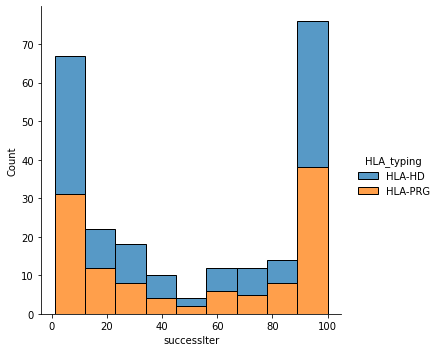

In [7]:
iterSize = mSDF.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize,hue='HLA_typing',kind="hist",multiple='stack')

In [44]:
iterSize[iterSize.successIter>=98]

HLA_typing      allele features  successIter
4       HLA-HD  DPB1*09:01      fx2          100
5       HLA-HD  DPB1*09:01      gx2          100
8       HLA-HD  DPB1*09:01      wx1          100
9       HLA-HD  DPB1*10:01      fx2           99
11      HLA-HD  DPB1*10:01      fx5          100
..         ...         ...      ...          ...
225    HLA-PRG  DRB1*15:02      wx1          100
226    HLA-PRG  DRB1*15:03      fx2          100
227    HLA-PRG  DRB1*15:03     phad          100
230    HLA-PRG  DRB1*16:01      fx2           98
232    HLA-PRG  DRB1*16:01     phad          100

[63 rows x 4 columns]

In [45]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)

0.75
0.75


HLA_typing
HLA-HD     98.0
HLA-PRG    99.0
Name: successIter, dtype: float64

In [144]:
successThreshold= 90
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter = iterSize[iterSize.successIter>=successThreshold].groupby(['allele','features']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter.groupby("TypingCons").size()

TypingCons
Both       33
HLA-HD      4
HLA-PRG     3
dtype: int64

In [145]:
iterSize[iterSize.allele=="DPB1*04:02"]

HLA_typing      allele features  successIter
1       HLA-HD  DPB1*04:02      fx2            2
2       HLA-HD  DPB1*04:02      fx5            9
3       HLA-HD  DPB1*04:02     phad            1
122    HLA-PRG  DPB1*04:02      fx2            1
123    HLA-PRG  DPB1*04:02      fx5          100
124    HLA-PRG  DPB1*04:02      wx1           11

In [146]:
aggCurated = pd.DataFrame()
for k in curatedFilter.index:
    if curatedFilter.loc[k,'TypingCons']=="Both":
        _tmpDF = mSDF[(mSDF.allele==curatedFilter.loc[k,'allele'])&(mSDF.features==curatedFilter.loc[k,'features'])][['coef','[0.025','0.975]','nlog10_Pval']].median().to_frame().T
        _tmpDF['allele'] = curatedFilter.loc[k,'allele']
        _tmpDF['allergenP'] = curatedFilter.loc[k,'features']
        _tmpDF['Typing'] = curatedFilter.loc[k,'TypingCons']
        aggCurated = pd.concat([aggCurated,_tmpDF],axis=0)
    else:
        _tmpDF = mSDF[(mSDF.allele==curatedFilter.loc[k,'allele'])&(mSDF.features==curatedFilter.loc[k,'features'])&(mSDF.HLA_typing==curatedFilter.loc[k,'TypingCons'])]\
                                                    [['coef','[0.025','0.975]','nlog10_Pval']].median().to_frame().T
        _tmpDF['allele'] = curatedFilter.loc[k,'allele']
        _tmpDF['allergenP'] = curatedFilter.loc[k,'features']
        _tmpDF['Typing'] = curatedFilter.loc[k,'TypingCons']
        aggCurated = pd.concat([aggCurated,_tmpDF],axis=0)


In [147]:
aggCurated.head()

coef  [0.025  0.975]  nlog10_Pval      allele allergenP   Typing
0  2.46275  1.8455  3.0800     8.838993  DPB1*04:02       fx5  HLA-PRG
0 -3.11095 -3.7195 -2.5090    17.270927  DPB1*09:01       fx2     Both
0 -2.57600 -3.2890 -1.8820     6.168794  DPB1*09:01       gx2     Both
0 -2.74620 -3.2390 -2.2515    21.424753  DPB1*09:01       wx1     Both
0 -1.54470 -2.0040 -1.0880     4.851955  DPB1*10:01       fx2     Both

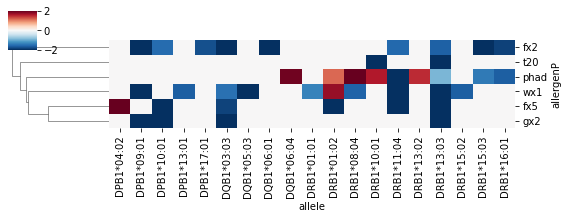

In [148]:
aggCurated = aggCurated.reset_index().drop('index',axis=1)
gxM1 = sns.clustermap(aggCurated.pivot(index='allergenP',columns='allele',values='coef').fillna(0),col_cluster=False,figsize=(8,3),vmin=-2,vmax=2,cmap="RdBu_r")

In [49]:
gxM1.data2d.shape

(6, 19)

In [149]:
colScl = ('#3A912A','#A4DF99','#F7F7F7','#D6BACE','#962A78')
both = alt.Chart(aggCurated[aggCurated.Typing=="Both"]).mark_point(filled=True).encode(
    x=alt.X('allele',sort=list(gxM1.data2d.columns),axis=alt.Axis(labelFontSize=12,title='')),
    y=alt.Y('allergenP',sort=list(gxM1.data2d.index),axis=alt.Axis(labelFontSize=12,title="Allergen Panel")),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef']
)
anyOne = alt.Chart(aggCurated[aggCurated.Typing!="Both"]).mark_rect(filled=True,size=10).encode(
    x=alt.X('allele',sort=list(gxM1.data2d.columns)),
    y=alt.Y('allergenP',sort=list(gxM1.data2d.index)),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True),legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10])),
    tooltip=['allele','coef','Typing','nlog10_Pval']
)
model1_mono = anyOne+both
model1_mono

alt.LayerChart(...)

In [150]:
model1_mono.save("../figures/monoSenz_Fig2A_12May2022.html")

In [60]:
model1_mono.save("../figures/monoSenz_Fig2A.png")

WARN size dropped as it is incompatible with "rect".


In [16]:
aggCurated[(aggCurated.coef<=-1.5)&(aggCurated.Typing=="Both")].sort_values(by='coef').allele.unique()

array(['DRB1*10:01', 'DRB1*15:03', 'DQB1*03:03', 'DQB1*05:03',
       'DRB1*13:03', 'DPB1*09:01', 'DRB1*01:02', 'DPB1*10:01',
       'DRB1*11:04', 'DQB1*06:01', 'DRB1*16:01', 'DRB1*15:02',
       'DPB1*13:01', 'DRB1*08:04'], dtype=object)

In [151]:
aggCurated.groupby("Typing").size()

Typing
Both       33
HLA-HD      4
HLA-PRG     3
dtype: int64

In [152]:
aggCurated.groupby(['Typing','allergenP']).size()

Typing   allergenP
Both     fx2           6
         fx5           4
         gx2           4
         phad          8
         t20           1
         wx1          10
HLA-HD   fx2           2
         fx5           1
         phad          1
HLA-PRG  fx2           1
         fx5           1
         t20           1
dtype: int64

In [153]:
m1DF_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))


for k in curatedFilter.index:
    _allele = curatedFilter.loc[k,'allele']
    _feature = curatedFilter.loc[k,'features']
    dx = mSDF[(mSDF.features==_feature)&(mSDF.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    dx['features'] = _feature
    m1DF_Curated = pd.concat([m1DF_Curated,dx],axis=0)
    
m1DF_Curated = m1DF_Curated.reset_index().drop('index',axis=1)


In [154]:
m1DF_Curated['test'] = m1DF_Curated.features+"_"+m1DF_Curated.allele
m1DF_Curated_prg = m1DF_Curated[m1DF_Curated.HLA_typing=="HLA-PRG"]
m1DF_Curated_hd = m1DF_Curated[m1DF_Curated.HLA_typing=="HLA-HD"]

In [155]:
m1DF_Curated_hd.head()

HLA_typing   iter    coef  [0.025  0.975]     pval_Holm      allele  \
0     HLA-HD    9.0  1.4970  1.0000  1.9920  9.890141e-04  DPB1*04:02   
2     HLA-HD  100.0 -3.1257 -3.7335 -2.5180  5.832914e-18  DPB1*09:01   
4     HLA-HD  100.0 -2.5506 -3.2510 -1.8565  7.580944e-07  DPB1*09:01   
6     HLA-HD  100.0 -2.7593 -3.2550 -2.2670  4.170050e-22  DPB1*09:01   
8     HLA-HD   99.0 -1.5394 -2.0010 -1.0790  1.820653e-05  DPB1*10:01   

  features            test  
0      fx5  fx5_DPB1*04:02  
2      fx2  fx2_DPB1*09:01  
4      gx2  gx2_DPB1*09:01  
6      wx1  wx1_DPB1*09:01  
8      fx2  fx2_DPB1*10:01

In [156]:
m1DF_Curated_prgX = m1DF_Curated_prg.set_index("test").join(m1DF_Curated_hd.set_index("test"),lsuffix="_LA").sort_values(by='coef')
m1DF_Curated_prgXAnnot = m1DF_Curated_prgX.join(alleleAllergenFreq.loc[m1DF_Curated_prgX.index][['posFrac_LA','negFrac_LA','posFrac_HD','negFrac_HD']]).sort_values(by=['coef_LA','pval_Holm_LA'])
# m1DF_Curated_prgXAnnot.to_csv("../tables/Monosensitization_sigAnnot.csv")

In [157]:
m1DF_Curated_prgXAnnot_curated = m1DF_Curated_prgXAnnot[['allele_LA','features_LA','iter_LA','coef_LA','[0.025_LA','0.975]_LA','pval_Holm_LA','posFrac_LA','negFrac_LA',
                       'iter','coef','[0.025','0.975]','pval_Holm','posFrac_HD','negFrac_HD',]]
for k in m1DF_Curated_prgXAnnot_curated.index:
    m1DF_Curated_prgXAnnot_curated.loc[k,'beta_LA'] = "{} ({},{})".format(round(m1DF_Curated_prgXAnnot_curated.loc[k,'coef_LA'],2),
                                                                         round(m1DF_Curated_prgXAnnot_curated.loc[k,'[0.025_LA'],2),
                                                                         round(m1DF_Curated_prgXAnnot_curated.loc[k,'0.975]_LA'],2))
    
    m1DF_Curated_prgXAnnot_curated.loc[k,'beta_HD'] = "{} ({},{})".format(round(m1DF_Curated_prgXAnnot_curated.loc[k,'coef'],2),
                                                                         round(m1DF_Curated_prgXAnnot_curated.loc[k,'[0.025'],2),
                                                                         round(m1DF_Curated_prgXAnnot_curated.loc[k,'0.975]'],2))
m1DF_Curated_prgXAnnot_curated_print = m1DF_Curated_prgXAnnot_curated[['allele_LA','features_LA','iter_LA','beta_LA','pval_Holm_LA','posFrac_LA','negFrac_LA','iter','beta_HD','pval_Holm','posFrac_HD','negFrac_HD']]

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/991697417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1DF_Curated_prgXAnnot_curated.loc[k,'beta_LA'] = "{} ({},{})".format(round(m1DF_Curated_prgXAnnot_curated.loc[k,'coef_LA'],2),
/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/991697417.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1DF_Curated_prgXAnnot_curated.loc[k,'beta_HD'] = "{} ({},{})".format(round(m1DF_Curated_prgXAnnot_curated.loc[k,'coef'],2),


In [158]:
m1DF_Curated_prgXAnnot_curated_print.loc[m1DF_Curated_prgXAnnot_curated_print[m1DF_Curated_prgXAnnot_curated_print[['iter_LA','iter']].min(axis=1)>90].index,'sigType']="High"
m1DF_Curated_prgXAnnot_curated_print.loc[m1DF_Curated_prgXAnnot_curated_print[m1DF_Curated_prgXAnnot_curated_print[['iter_LA','iter']].min(axis=1)<=90].index,'sigType']="Low"

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/4016156705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m1DF_Curated_prgXAnnot_curated_print.loc[m1DF_Curated_prgXAnnot_curated_print[m1DF_Curated_prgXAnnot_curated_print[['iter_LA','iter']].min(axis=1)>90].index,'sigType']="High"


In [159]:
m1DF_Curated_prgXAnnot_curated_print.groupby('sigType').size()

sigType
High    32
Low      8
dtype: int64

In [160]:
m1DF_Curated_prgXAnnot_curated_print.to_csv("../tables/Monosensitization_sigAnnot_12May2022.csv")

In [161]:
### For plotting

def gfunction(kgrp):
    _sr = pd.Series((kgrp.coef.mean(),kgrp['[0.025'].mean(),kgrp['0.975]'].mean()
                     ,kgrp['pval_Holm'].mean()),
                    index=('coef','lCI','mCI','pval_Holm'))
    if kgrp['HLA_typing'].nunique()==2:
        _sr['method']='Both'
    else:
        _sr['method']=kgrp['HLA_typing'].unique()[0]
    return (_sr)


m1DF_2methAGG = m1DF_Curated.groupby(['allele','features'])[['coef','[0.025','0.975]','pval_Holm','HLA_typing']].apply(gfunction).reset_index()

In [162]:
m1DF_2methAGG

allele features      coef      lCI      mCI     pval_Holm method
0   DPB1*04:02      fx5  1.979875  1.42275  2.53600  4.945078e-04   Both
1   DPB1*09:01      fx2 -3.115600 -3.72450 -2.51000  5.584658e-18   Both
2   DPB1*09:01      gx2 -2.581250 -3.28800 -1.87125  6.902192e-07   Both
3   DPB1*09:01      wx1 -2.746000 -3.24050 -2.25375  3.607578e-22   Both
4   DPB1*10:01      fx2 -1.549800 -2.01275 -1.08925  1.473427e-05   Both
5   DPB1*10:01      fx5 -2.638700 -3.31625 -1.94675  2.220969e-08   Both
6   DPB1*10:01      gx2 -2.391975 -2.98950 -1.79450  9.056853e-10   Both
7   DPB1*13:01      wx1 -1.650075 -2.07550 -1.22500  3.359780e-08   Both
8   DPB1*17:01      fx2 -1.622825 -2.09325 -1.16050  6.978842e-05   Both
9   DQB1*03:03      fx2 -4.580550 -5.50300 -3.64200  2.408372e-16   Both
10  DQB1*03:03      fx5 -1.867425 -2.45625 -1.27750  1.618015e-04   Both
11  DQB1*03:03      gx2 -2.404550 -3.06925 -1.73550  6.879606e-07   Both
12  DQB1*03:03      wx1 -1.500075 -1.88750 -1.11100  2.410110e-08   Both
13  DQB1*05:03      wx1 -3.487725 -4.17225 -2.81000  3.251039e-18   Both
14  DQB1*06:01      fx2 -2.359950 -3.03600 -1.69350  5.280479e-06   Both
15  DQB1*06:04     phad  1.938800  1.61100  2.26800  1.668696e-25   Both
16  DRB1*01:01      wx1 -1.336075 -1.70325 -0.97075  4.081120e-07   Both
17  DRB1*01:02      fx5 -2.841675 -3.61450 -2.05675  4.459290e-07   Both
18  DRB1*01:02     phad  1.149325  0.86450  1.43325  7.037585e-10   Both
19  DRB1*01:02      wx1  1.746200  1.40775  2.08700  3.362084e-18   Both
20  DRB1*08:04     phad  2.003050  1.61150  2.39725  6.798428e-18   Both
21  DRB1*08:04      wx1 -1.617100 -2.02475 -1.21075  2.461831e-09   Both
22  DRB1*10:01     phad  1.599350  1.26450  1.93600  4.863222e-15   Both
23  DRB1*10:01      t20 -5.238450 -6.71925 -3.78725  7.332886e-07   Both
24  DRB1*11:04      fx2 -1.583375 -2.05050 -1.11750  1.212403e-05   Both
25  DRB1*11:04      fx5 -2.473450 -3.21725 -1.71725  1.757202e-05   Both
26  DRB1*11:04     phad -2.499325 -2.86900 -2.13025  1.647470e-34   Both
27  DRB1*11:04      wx1 -2.481025 -2.95775 -2.00625  7.022060e-19   Both
28  DRB1*13:02     phad  1.497050  1.16975  1.82650  1.262756e-13   Both
29  DRB1*13:03      fx2 -1.463625 -1.88250 -1.04475  4.518292e-05   Both
30  DRB1*13:03      fx5 -2.447000 -3.16700 -1.72575  5.841749e-05   Both
31  DRB1*13:03      gx2 -3.366025 -4.26275 -2.47175  2.619183e-07   Both
32  DRB1*13:03     phad -0.880825 -1.15500 -0.60700  1.275795e-04   Both
33  DRB1*13:03      t20 -2.000950 -2.63500 -1.36050  8.752439e-04   Both
34  DRB1*13:03      wx1 -2.426150 -2.88325 -1.96950  2.131613e-19   Both
35  DRB1*15:02      wx1 -1.646650 -2.05175 -1.24050  8.224474e-10   Both
36  DRB1*15:03      fx2 -4.954025 -5.98075 -3.93825  7.966061e-16   Both
37  DRB1*15:03     phad -1.406550 -1.73450 -1.07375  2.555918e-11   Both
38  DRB1*16:01      fx2 -1.875025 -2.38800 -1.35800  4.386303e-07   Both
39  DRB1*16:01     phad -1.667400 -2.03675 -1.29875  1.408507e-10   Both

### Association with multiple allergen panels

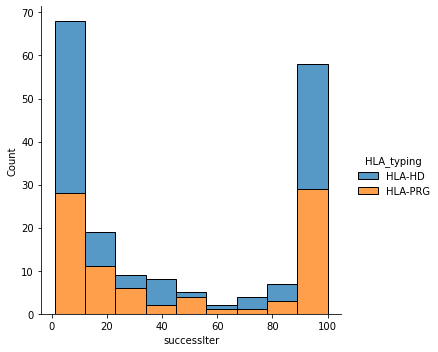

In [163]:
m2PS = pd.read_csv("../AssociationResults/PolySensitization_Model2_100_02-13-22_08:40:39.csv")
m2PS_sig = m2PS[(m2PS.pval_Holm<=0.005)&(abs(m2PS.coef)>np.log(2))]

m2PS_sig= m2PS_sig.reset_index().drop(['index','Unnamed: 0'],axis=1)
m2PS_sig['AlleleAllergen'] = m2PS_sig.features+"_"+m2PS_sig.allele

iterSize_m2 = m2PS_sig.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize_m2,hue='HLA_typing',multiple="stack")

In [67]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize_m2.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)


0.75
0.75


HLA_typing
HLA-HD     91.5
HLA-PRG    96.0
Name: successIter, dtype: float64

In [164]:
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter_m2 = iterSize_m2[iterSize_m2.successIter>=successThreshold].groupby(['allele','features']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter_m2.head()

allele features TypingCons
0  DPB1*04:02      fx2    HLA-PRG
1  DPB1*09:01      fx2       Both
2  DPB1*09:01     phad    HLA-PRG
3  DPB1*09:01      wx1       Both
4  DPB1*10:01     phad       Both

In [165]:
curatedFilter_m2.groupby("TypingCons").size()

TypingCons
Both       25
HLA-HD      3
HLA-PRG     3
dtype: int64

In [166]:
curatedFilter_m2.sort_values(by=['allele','features'])

allele features TypingCons
0   DPB1*04:02      fx2    HLA-PRG
1   DPB1*09:01      fx2       Both
2   DPB1*09:01     phad    HLA-PRG
3   DPB1*09:01      wx1       Both
4   DPB1*10:01     phad       Both
5   DPB1*13:01      wx1       Both
6   DPB1*17:01      fx2       Both
7   DQA1*01:01      fx2     HLA-HD
8   DQB1*03:03      fx2       Both
9   DQB1*05:01     phad       Both
10  DQB1*05:03      wx1     HLA-HD
11  DQB1*06:03      fx5       Both
12  DQB1*06:04     phad       Both
13  DRB1*01:02      fx5       Both
14  DRB1*01:02      t20       Both
15  DRB1*01:02      wx1       Both
16  DRB1*08:04      fx2       Both
17  DRB1*08:04     phad       Both
18  DRB1*10:01     phad       Both
19  DRB1*10:01      wx1       Both
20  DRB1*11:01      wx1       Both
21  DRB1*11:04      fx5       Both
22  DRB1*11:04     phad       Both
23  DRB1*13:01      fx5       Both
24  DRB1*13:02     phad       Both
25  DRB1*13:03     phad       Both
26  DRB1*13:03      wx1     HLA-HD
27  DRB1*15:03      fx2       Both
28  DRB1*15:03     phad       Both
29  DRB1*16:01      fx5    HLA-PRG
30  DRB1*16:01     phad       Both

In [167]:
m2DF_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))

for k in curatedFilter_m2.index:
    _allele = curatedFilter_m2.loc[k,'allele']
    _feature = curatedFilter_m2.loc[k,'features']
    dx = m2PS_sig[(m2PS_sig.features==_feature)&(m2PS_sig.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    dx['features'] = _feature
    m2DF_Curated = pd.concat([m2DF_Curated,dx],axis=0)
    
m2DF_Curated = m2DF_Curated.reset_index().drop('index',axis=1)

m2DF_Curated['test'] = m2DF_Curated.features+"_"+m2DF_Curated.allele
m2DF_Curated_prg = m2DF_Curated[m2DF_Curated.HLA_typing=="HLA-PRG"]
m2DF_Curated_hd = m2DF_Curated[m2DF_Curated.HLA_typing=="HLA-HD"]

m2DF_Curated_agg = m2DF_Curated_prg.set_index("test").join(m2DF_Curated_hd.set_index("test"),lsuffix="_LA").sort_index()

In [168]:
m2PS_sig.head()

coef  std err      z  P>|z|  [0.025  0.975]    pvalue_raw features  iter  \
0 -1.6936    0.266 -6.360    0.0  -2.216  -1.172  2.019905e-10      fx2     2   
1 -1.6430    0.270 -6.079    0.0  -2.173  -1.113  1.206882e-09      fx2     4   
2 -1.5144    0.255 -5.949    0.0  -2.013  -1.015  2.694126e-09      fx2    22   
3 -1.3257    0.247 -5.369    0.0  -1.810  -0.842  7.909726e-08      fx2    29   
4 -1.6193    0.279 -5.796    0.0  -2.167  -1.072  6.787199e-09      fx2    49   

       allele HLA_typing  pval_Holm  nlog10_Pval  AlleleAllergen  
0  DPA1*02:02     HLA-HD   0.000013     4.878740  fx2_DPA1*02:02  
1  DPA1*02:02     HLA-HD   0.000078     4.106881  fx2_DPA1*02:02  
2  DPA1*02:02     HLA-HD   0.000174     3.760683  fx2_DPA1*02:02  
3  DPA1*02:02     HLA-HD   0.004951     2.305278  fx2_DPA1*02:02  
4  DPA1*02:02     HLA-HD   0.000434     3.362632  fx2_DPA1*02:02

In [169]:
m2DF_Curated_agg.sort_values(by='coef')

HLA_typing_LA  iter_LA  coef_LA  [0.025_LA  0.975]_LA  \
test                                                                    
fx2_DQB1*03:03        HLA-PRG     95.0 -4.38930    -5.6380    -3.1350   
fx5_DRB1*11:04        HLA-PRG    100.0 -3.57950    -4.7450    -2.4435   
fx2_DRB1*15:03        HLA-PRG    100.0 -3.61100    -4.4795    -2.7420   
fx5_DRB1*13:01        HLA-PRG    100.0 -3.56935    -4.6550    -2.4655   
fx5_DRB1*01:02        HLA-PRG    100.0 -3.75870    -4.8305    -2.6815   
fx5_DQB1*06:03        HLA-PRG     97.0 -3.39930    -4.5070    -2.2960   
t20_DRB1*01:02        HLA-PRG     99.0 -3.24190    -4.2130    -2.2700   
fx2_DPB1*09:01        HLA-PRG     96.0 -3.22730    -3.9715    -2.4910   
wx1_DQB1*05:03        HLA-PRG     85.0 -3.07620    -3.9020    -2.2680   
wx1_DRB1*13:03        HLA-PRG     29.0 -1.83280    -2.4550    -1.2000   
wx1_DPB1*13:01        HLA-PRG    100.0 -2.76425    -3.3740    -2.1580   
wx1_DPB1*09:01        HLA-PRG     96.0 -2.46075    -3.0840    -1.8335   
fx5_DRB1*16:01        HLA-PRG     90.0 -2.47010    -3.3125    -1.6385   
fx2_DRB1*08:04        HLA-PRG     93.0 -2.38390    -3.0530    -1.7140   
wx1_DRB1*11:01        HLA-PRG    100.0 -2.30200    -2.8620    -1.7470   
phad_DRB1*11:04       HLA-PRG    100.0 -2.07950    -2.4725    -1.6865   
fx2_DPB1*17:01        HLA-PRG     99.0 -1.62080    -2.0670    -1.1730   
phad_DRB1*16:01       HLA-PRG    100.0 -1.71165    -2.0595    -1.3595   
wx1_DRB1*10:01        HLA-PRG    100.0 -1.80530    -2.3235    -1.2845   
fx2_DPB1*04:02        HLA-PRG    100.0 -1.98960    -2.4995    -1.4730   
phad_DRB1*15:03       HLA-PRG    100.0 -1.33635    -1.6705    -1.0065   
phad_DPB1*10:01       HLA-PRG     98.0 -1.25935    -1.6065    -0.9090   
phad_DRB1*13:03       HLA-PRG     97.0 -1.39270    -1.7570    -1.0280   
phad_DPB1*09:01       HLA-PRG     96.0  1.21970     0.8710     1.5700   
phad_DQB1*05:01       HLA-PRG     99.0  1.41740     1.0280     1.8120   
phad_DQB1*06:04       HLA-PRG    100.0  1.52860     1.2115     1.8480   
phad_DRB1*13:02       HLA-PRG    100.0  1.48815     1.1505     1.8275   
phad_DRB1*08:04       HLA-PRG     94.0  1.52650     1.1605     1.8935   
wx1_DRB1*01:02        HLA-PRG    100.0  1.54815     1.1495     1.9470   
phad_DRB1*10:01       HLA-PRG    100.0  1.93200     1.5610     2.3060   

                 pval_Holm_LA   allele_LA features_LA HLA_typing   iter  \
test                                                                      
fx2_DQB1*03:03   4.027318e-07  DQB1*03:03         fx2     HLA-HD   91.0   
fx5_DRB1*11:04   3.034133e-05  DRB1*11:04         fx5     HLA-HD  100.0   
fx2_DRB1*15:03   4.302295e-11  DRB1*15:03         fx2     HLA-HD  100.0   
fx5_DRB1*13:01   5.775726e-06  DRB1*13:01         fx5     HLA-HD  100.0   
fx5_DRB1*01:02   4.557936e-07  DRB1*01:02         fx5     HLA-HD   99.0   
fx5_DQB1*06:03   6.233051e-05  DQB1*06:03         fx5     HLA-HD   97.0   
t20_DRB1*01:02   4.215829e-06  DRB1*01:02         t20     HLA-HD  100.0   
fx2_DPB1*09:01   6.913778e-13  DPB1*09:01         fx2     HLA-HD   91.0   
wx1_DQB1*05:03   1.551145e-08  DQB1*05:03         wx1     HLA-HD   90.0   
wx1_DRB1*13:03   1.080518e-03  DRB1*13:03         wx1     HLA-HD   95.0   
wx1_DPB1*13:01   2.731218e-14  DPB1*13:01         wx1     HLA-HD   99.0   
wx1_DPB1*09:01   6.977367e-10  DPB1*09:01         wx1     HLA-HD   91.0   
fx5_DRB1*16:01   4.421046e-04  DRB1*16:01         fx5     HLA-HD   74.0   
fx2_DRB1*08:04   4.059827e-07  DRB1*08:04         fx2     HLA-HD   94.0   
wx1_DRB1*11:01   3.430553e-11  DRB1*11:01         wx1     HLA-HD  100.0   
phad_DRB1*11:04  1.780619e-20  DRB1*11:04        phad     HLA-HD  100.0   
fx2_DPB1*17:01   7.521094e-08  DPB1*17:01         fx2     HLA-HD  100.0   
phad_DRB1*16:01  4.793309e-17  DRB1*16:01        phad     HLA-HD  100.0   
wx1_DRB1*10:01   8.352103e-07  DRB1*10:01         wx1     HLA-HD  100.0   
fx2_DPB1*04:02   2.840241e-09  DPB1*04:02         fx2     HLA-HD   40.0   
phad_DRB1*15:03  3.652842e-10

In [170]:
aggCurated_m2 = pd.DataFrame()
for k in curatedFilter_m2.index:
    _allele = curatedFilter_m2.loc[k,'allele']
    _allergen = curatedFilter_m2.loc[k,'features']
    _typing = curatedFilter_m2.loc[k,'TypingCons']
    
    if _typing=="Both":
        _tmpDF = m2PS_sig[(m2PS_sig.allele==_allele)&(m2PS_sig.features==_allergen)][['coef','[0.025','0.975]','pval_Holm']].median().to_frame().T
        _tmpDF['allele'] = _allele
        _tmpDF['allergenP'] = _allergen
        _tmpDF['Typing'] = _typing
        aggCurated_m2 = pd.concat([aggCurated_m2,_tmpDF],axis=0)
    else:
        _tmpDF = m2PS_sig[(m2PS_sig.allele==_allele)&(m2PS_sig.features==_allergen)&(m2PS_sig.HLA_typing==_typing)]\
                                                    [['coef','[0.025','0.975]','pval_Holm']].median().to_frame().T
        _tmpDF['allele'] = _allele
        _tmpDF['allergenP'] = _allergen
        _tmpDF['Typing'] = _typing
        aggCurated_m2 = pd.concat([aggCurated_m2,_tmpDF],axis=0)
aggCurated_m2.head()

coef  [0.025  0.975]     pval_Holm      allele allergenP   Typing
0 -1.9896 -2.4995  -1.473  2.840241e-09  DPB1*04:02       fx2  HLA-PRG
0 -3.1767 -3.9010  -2.449  8.751981e-13  DPB1*09:01       fx2     Both
0  1.2197  0.8710   1.570  4.709946e-07  DPB1*09:01      phad  HLA-PRG
0 -2.4973 -3.1330  -1.860  7.564102e-10  DPB1*09:01       wx1     Both
0 -1.2591 -1.6060  -0.916  6.169764e-08  DPB1*10:01      phad     Both

In [171]:
aggCurated_m2.groupby("Typing").size()

Typing
Both       25
HLA-HD      3
HLA-PRG     3
dtype: int64

In [172]:
aggCurated_m2 = aggCurated_m2.reset_index().drop('index',axis=1)
aggCurated_m2.sort_values(by=['allele','allergenP'])

coef  [0.025  0.975]     pval_Holm      allele allergenP   Typing
0  -1.98960 -2.4995 -1.4730  2.840241e-09  DPB1*04:02       fx2  HLA-PRG
1  -3.17670 -3.9010 -2.4490  8.751981e-13  DPB1*09:01       fx2     Both
2   1.21970  0.8710  1.5700  4.709946e-07  DPB1*09:01      phad  HLA-PRG
3  -2.49730 -3.1330 -1.8600  7.564102e-10  DPB1*09:01       wx1     Both
4  -1.25910 -1.6060 -0.9160  6.169764e-08  DPB1*10:01      phad     Both
5  -2.69480 -3.2850 -2.0890  1.360022e-13  DPB1*13:01       wx1     Both
6  -1.79870 -2.2610 -1.3400  8.407582e-10  DPB1*17:01       fx2     Both
7  -1.56195 -2.0425 -1.0815  1.013032e-05  DQA1*01:01       fx2   HLA-HD
8  -4.38895 -5.6280 -3.1380  4.707503e-07  DQB1*03:03       fx2     Both
9   1.41370  1.0235  1.8040  1.403704e-07  DQB1*05:01      phad     Both
10 -3.07820 -3.9025 -2.2610  1.031504e-08  DQB1*05:03       wx1   HLA-HD
11 -3.43750 -4.5345 -2.3495  6.672007e-05  DQB1*06:03       fx5     Both
12  1.51755  1.1995  1.8375  6.126119e-16  DQB1*06:04      phad     Both
13 -3.69650 -4.7450 -2.6370  5.242892e-07  DRB1*01:02       fx5     Both
14 -3.24090 -4.1960 -2.2590  3.753464e-06  DRB1*01:02       t20     Both
15  1.53135  1.1385  1.9295  1.878930e-09  DRB1*01:02       wx1     Both
16 -2.33040 -2.9930 -1.6580  7.167547e-07  DRB1*08:04       fx2     Both
17  1.52110  1.1545  1.8885  3.666276e-11  DRB1*08:04      phad     Both
18  1.93950  1.5650  2.3080  5.891766e-20  DRB1*10:01      phad     Both
19 -1.80755 -2.3255 -1.2855  7.589663e-07  DRB1*10:01       wx1     Both
20 -2.27030 -2.8230 -1.7150  1.082893e-10  DRB1*11:01       wx1     Both
21 -3.62400 -4.7660 -2.4695  3.075260e-05  DRB1*11:04       fx5     Both
22 -2.07090 -2.4595 -1.6835  1.780619e-20  DRB1*11:04      phad     Both
23 -3.58900 -4.6760 -2.4975  6.056046e-06  DRB1*13:01       fx5     Both
24  1.49320  1.1515  1.8330  3.812250e-13  DRB1*13:02      phad     Both
25 -1.26525 -1.6215 -0.9100  1.683452e-07  DRB1*13:03      phad     Both
26 -2.73570 -3.5110 -1.9160  2.728124e-06  DRB1*13:03       wx1   HLA-HD
27 -3.62765 -4.5015 -2.7540  4.013247e-11  DRB1*15:03       fx2     Both
28 -1.29375 -1.6290 -0.9585  1.758015e-09  DRB1*15:03      phad     Both
29 -2.47010 -3.3125 -1.6385  4.421046e-04  DRB1*16:01       fx5  HLA-PRG
30 -1.82730 -2.1800 -1.4740  9.507687e-20  DRB1*16:01      phad     Both

In [173]:
aggCurated_m2_pivot = aggCurated_m2.pivot(index='allele',columns='allergenP',values='coef').fillna(0)

In [174]:
aggCurated_m2['nlog10_Pval'] = np.log10(aggCurated_m2.pval_Holm)
aggCurated_m2.head()

coef  [0.025  0.975]     pval_Holm      allele allergenP   Typing  \
0 -1.9896 -2.4995  -1.473  2.840241e-09  DPB1*04:02       fx2  HLA-PRG   
1 -3.1767 -3.9010  -2.449  8.751981e-13  DPB1*09:01       fx2     Both   
2  1.2197  0.8710   1.570  4.709946e-07  DPB1*09:01      phad  HLA-PRG   
3 -2.4973 -3.1330  -1.860  7.564102e-10  DPB1*09:01       wx1     Both   
4 -1.2591 -1.6060  -0.916  6.169764e-08  DPB1*10:01      phad     Both   

   nlog10_Pval  
0    -8.546645  
1   -12.057894  
2    -6.326984  
3    -9.121243  
4    -7.209731

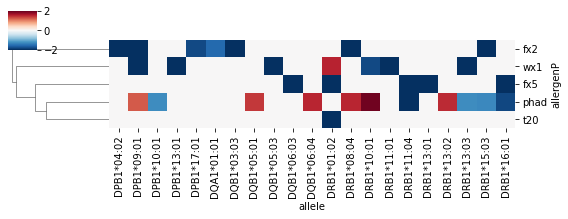

In [175]:
gxM2 = sns.clustermap(aggCurated_m2_pivot.T,col_cluster=False,figsize=(8,3),vmin=-2,vmax=2,cmap="RdBu_r")

In [176]:
colScl = ('#3A912A','#A4DF99','#F7F7F7','#D6BACE','#962A78')
both_m2 = alt.Chart(aggCurated_m2[aggCurated_m2.Typing=="Both"]).mark_point(filled=True).encode(
    x=alt.X('allele',sort=list(gxM2.data2d.columns),axis=alt.Axis(labelFontSize=12,title='')),
    y=alt.Y('allergenP',sort=list(gxM2.data2d.index),axis=alt.Axis(labelFontSize=12,title="Allergen Panel")),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True), legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef']
)
anyOne_m2 = alt.Chart(aggCurated_m2[aggCurated_m2.Typing!="Both"]).mark_rect(filled=True,size=10).encode(
    x=alt.X('allele',sort=list(gxM2.data2d.columns)),
    y=alt.Y('allergenP',sort=list(gxM2.data2d.index)),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True),legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef','Typing','nlog10_Pval']
)
multiPanelSens = anyOne_m2+both_m2

In [177]:
multiPanelSens

alt.LayerChart(...)

In [178]:
multiPanelSens.save("../figures/MultiPanle_model2_12May2022.html")

In [179]:
m2DF_Curated_aggJ = m2DF_Curated_agg.join(alleleAllergenFreq.loc[m2DF_Curated_agg.index][['posFrac_LA','negFrac_LA','posFrac_HD','negFrac_HD']]).sort_values(by='coef')
# m2DF_Curated_aggJ.to_csv("../tables/model2_aggAssociations.csv")
m2DF_Curated_aggJ.head()

HLA_typing_LA  iter_LA  coef_LA  [0.025_LA  0.975]_LA  \
test                                                                   
fx2_DQB1*03:03       HLA-PRG     95.0 -4.38930    -5.6380    -3.1350   
fx5_DRB1*11:04       HLA-PRG    100.0 -3.57950    -4.7450    -2.4435   
fx2_DRB1*15:03       HLA-PRG    100.0 -3.61100    -4.4795    -2.7420   
fx5_DRB1*13:01       HLA-PRG    100.0 -3.56935    -4.6550    -2.4655   
fx5_DRB1*01:02       HLA-PRG    100.0 -3.75870    -4.8305    -2.6815   

                pval_Holm_LA   allele_LA features_LA HLA_typing   iter  \
test                                                                     
fx2_DQB1*03:03  4.027318e-07  DQB1*03:03         fx2     HLA-HD   91.0   
fx5_DRB1*11:04  3.034133e-05  DRB1*11:04         fx5     HLA-HD  100.0   
fx2_DRB1*15:03  4.302295e-11  DRB1*15:03         fx2     HLA-HD  100.0   
fx5_DRB1*13:01  5.775726e-06  DRB1*13:01         fx5     HLA-HD  100.0   
fx5_DRB1*01:02  4.557936e-07  DRB1*01:02         fx5     HLA-HD   99.0   

                   coef  [0.025  0.975]     pval_Holm      allele features  \
test                                                                         
fx2_DQB1*03:03 -4.38710 -5.6260 -3.1410  5.601172e-07  DQB1*03:03      fx2   
fx5_DRB1*11:04 -3.65380 -4.8145 -2.5210  3.292830e-05  DRB1*11:04      fx5   
fx2_DRB1*15:03 -3.64025 -4.5085 -2.7635  3.276198e-11  DRB1*15:03      fx2   
fx5_DRB1*13:01 -3.60715 -4.6980 -2.5165  6.197682e-06  DRB1*13:01      fx5   
fx5_DRB1*01:02 -3.58660 -4.5980 -2.5650  5.571868e-07  DRB1*01:02      fx5   

                posFrac_LA  negFrac_LA  posFrac_HD  negFrac_HD  
test                                                            
fx2_DQB1*03:03    0.111111    0.201540    0.111111    0.201540  
fx5_DRB1*11:04    0.088889    0.128989    0.088889    0.128989  
fx2_DRB1*15:03    0.111111    0.201540    0.111111    0.201540  
fx5_DRB1*13:01    0.148148    0.125168    0.148148    0.125168  
fx5_DRB1*01:02    0.086957    0.127907    0.086957    0.127907

In [180]:
for k in m2DF_Curated_aggJ.index:
    m2DF_Curated_aggJ.loc[k,'beta_LA'] = "{} ({},{})".format(round(m2DF_Curated_aggJ.loc[k,'coef_LA'],2),
                                                                         round(m2DF_Curated_aggJ.loc[k,'[0.025_LA'],2),
                                                                         round(m2DF_Curated_aggJ.loc[k,'0.975]_LA'],2))
    
    m2DF_Curated_aggJ.loc[k,'beta_HD'] = "{} ({},{})".format(round(m2DF_Curated_aggJ.loc[k,'coef'],2),
                                                                         round(m2DF_Curated_aggJ.loc[k,'[0.025'],2),
                                                                         round(m2DF_Curated_aggJ.loc[k,'0.975]'],2))
m2DF_Curated_aggJ_print = m2DF_Curated_aggJ[['allele_LA','features_LA','iter_LA','beta_LA','pval_Holm_LA','posFrac_LA','negFrac_LA','iter','beta_HD','pval_Holm','posFrac_HD','negFrac_HD']]

In [181]:
m2DF_Curated_aggJ_print.loc[m2DF_Curated_aggJ_print[m2DF_Curated_aggJ_print[['iter_LA','iter']].min(axis=1)>90].index,'sigType']="High"
m2DF_Curated_aggJ_print.loc[m2DF_Curated_aggJ_print[m2DF_Curated_aggJ_print[['iter_LA','iter']].min(axis=1)<=90].index,'sigType']="Low"
m2DF_Curated_aggJ_print.groupby("sigType").size()

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/3151575895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m2DF_Curated_aggJ_print.loc[m2DF_Curated_aggJ_print[m2DF_Curated_aggJ_print[['iter_LA','iter']].min(axis=1)>90].index,'sigType']="High"


sigType
High    25
Low      5
dtype: int64

In [182]:
m2DF_Curated_aggJ_print.to_csv("../tables/model2_aggAssociations_12May2022.csv")

In [183]:
# Merging two figures
colScl = ('#3A912A','#A4DF99','#F7F7F7','#D6BACE','#962A78')
both = alt.Chart(aggCurated[aggCurated.Typing=="Both"],width=400,height=120).mark_point(filled=True).encode(
    x=alt.X('allele',sort=list(gxM1.data2d.columns),axis=alt.Axis(labelFontSize=12,title='')),
    y=alt.Y('allergenP',sort=list(gxM1.data2d.index),axis=alt.Axis(labelFontSize=12,title="Association for single allergen panel")),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef']
)
anyOne = alt.Chart(aggCurated[aggCurated.Typing!="Both"],width=400,height=120).mark_rect(filled=True,size=10).encode(
    x=alt.X('allele',sort=list(gxM1.data2d.columns)),
    y=alt.Y('allergenP',sort=list(gxM1.data2d.index)),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True),legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10])),
    tooltip=['allele','coef','Typing','nlog10_Pval']
)
model1_mono = anyOne+both

both_m2 = alt.Chart(aggCurated_m2[aggCurated_m2.Typing=="Both"],width=400,height=120).mark_point(filled=True).encode(
    x=alt.X('allele',sort=list(gxM2.data2d.columns),axis=alt.Axis(labelFontSize=12,title='')),
    y=alt.Y('allergenP',sort=list(gxM2.data2d.index),axis=alt.Axis(labelFontSize=12,title="Association for combined allergen panel")),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True), legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef']
)
anyOne_m2 = alt.Chart(aggCurated_m2[aggCurated_m2.Typing!="Both"],width=400,height=120).mark_rect(filled=True,size=10).encode(
    x=alt.X('allele',sort=list(gxM2.data2d.columns)),
    y=alt.Y('allergenP',sort=list(gxM2.data2d.index)),
    color=alt.Color('coef',scale=alt.Scale(domain=[-2,-1,0,1,2],range=colScl,clamp=True),legend=alt.Legend(title='\u03b2',titleFontSize=12)),
    size=alt.Size('nlog10_Pval',legend=alt.Legend(values=[3,5,10],title='-Log(P-value)',titleFontSize=12)),
    tooltip=['allele','coef','Typing','nlog10_Pval']
)
multiPanelSens = anyOne_m2+both_m2

Figure2 = alt.vconcat(model1_mono,multiPanelSens)

In [184]:
Figure2

alt.VConcatChart(...)

### Merging Mono-Panel and Multi-Panel sensitization measure

In [185]:
set(m2DF_Curated_aggJ.index).intersection(set(m1DF_Curated_prgXAnnot.index))

{'fx2_DPB1*09:01',
 'fx2_DPB1*17:01',
 'fx2_DQB1*03:03',
 'fx2_DRB1*15:03',
 'fx5_DRB1*01:02',
 'fx5_DRB1*11:04',
 'phad_DQB1*06:04',
 'phad_DRB1*08:04',
 'phad_DRB1*10:01',
 'phad_DRB1*11:04',
 'phad_DRB1*13:02',
 'phad_DRB1*13:03',
 'phad_DRB1*15:03',
 'phad_DRB1*16:01',
 'wx1_DPB1*09:01',
 'wx1_DPB1*13:01',
 'wx1_DQB1*05:03',
 'wx1_DRB1*01:02',
 'wx1_DRB1*13:03'}

In [186]:
mono_multi = set(m2DF_Curated_aggJ.index).union(set(m1DF_Curated_prgXAnnot.index))
print (len(mono_multi))

51


In [187]:
m1DF_monoMulti = mSDF[mSDF.AlleleAllergen.isin(mono_multi)].reset_index().drop("index",axis=1)
m1DF_monoMulti['model'] = "Mono"
m2DF_monoMulti = m2PS_sig[m2PS_sig.AlleleAllergen.isin(mono_multi)].reset_index().drop("index",axis=1)
m2DF_monoMulti['model'] = "Ploy"

print (m1DF_monoMulti.shape, m2DF_monoMulti.shape)

(8070, 15) (6412, 15)


In [188]:
monoMultiDF = pd.concat([m1DF_monoMulti,m2DF_monoMulti],axis=0)

In [189]:
def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))

monoMultiDFGrp = monoMultiDF.groupby(['model','HLA_typing','AlleleAllergen']).apply(valAggregate)

In [190]:
monoMultiDFGrp_Tab = pd.DataFrame()
for kname, kgrp in monoMultiDFGrp.reset_index().groupby(["model","HLA_typing"])[['AlleleAllergen','iter','coef','[0.025','0.975]','pval_Holm']]:
    print ('_'.join(kname),kgrp.columns)
    _nsufx = '_'.join(kname)
    rnCol = {'iter':'iter_{}'.format(_nsufx),'coef':'coef_{}'.format(_nsufx),'[0.025':'lCI_{}'.format(_nsufx),'0.975]':'mCI_{}'.format(_nsufx), 'pval_Holm':'pval_{}'.format(_nsufx)}
    kgrp_tmp = kgrp.set_index('AlleleAllergen')[list(rnCol.keys())].rename(rnCol,axis=1)
    monoMultiDFGrp_Tab = pd.concat([monoMultiDFGrp_Tab,kgrp_tmp],axis=1)

Mono_HLA-HD Index(['AlleleAllergen', 'iter', 'coef', '[0.025', '0.975]', 'pval_Holm'], dtype='object')
Mono_HLA-PRG Index(['AlleleAllergen', 'iter', 'coef', '[0.025', '0.975]', 'pval_Holm'], dtype='object')
Ploy_HLA-HD Index(['AlleleAllergen', 'iter', 'coef', '[0.025', '0.975]', 'pval_Holm'], dtype='object')
Ploy_HLA-PRG Index(['AlleleAllergen', 'iter', 'coef', '[0.025', '0.975]', 'pval_Holm'], dtype='object')


In [191]:
monoMultiDFGrp_Tab

iter_Mono_HLA-HD  coef_Mono_HLA-HD  lCI_Mono_HLA-HD  \
AlleleAllergen                                                         
fx2_DPB1*04:02                2.0          -1.23020          -1.6415   
fx2_DPB1*09:01              100.0          -3.12570          -3.7335   
fx2_DPB1*10:01               99.0          -1.53940          -2.0010   
fx2_DPB1*17:01              100.0          -1.75455          -2.2135   
fx2_DQB1*03:03               98.0          -4.53130          -5.4430   
fx2_DQB1*06:01               95.0          -2.31940          -2.9860   
fx2_DRB1*08:04               40.0          -1.74470          -2.3205   
fx2_DRB1*11:04               84.0          -1.59100          -2.0620   
fx2_DRB1*13:03              100.0          -1.63720          -2.0740   
fx2_DRB1*15:03               98.0          -5.04960          -6.0970   
fx2_DRB1*16:01               99.0          -1.83540          -2.3430   
fx5_DPB1*04:02                9.0           1.49700           1.0000   
fx5_DPB1*10:01              100.0          -2.65650          -3.3425   
fx5_DQB1*03:03               92.0          -1.84995          -2.4375   
fx5_DQB1*06:03                1.0          -1.89150          -2.5320   
fx5_DRB1*01:02              100.0          -2.85365          -3.6310   
fx5_DRB1*11:04               96.0          -2.41800          -3.1535   
fx5_DRB1*13:01                1.0          -1.80040          -2.4130   
fx5_DRB1*13:03               90.0          -2.27200          -2.9720   
fx5_DRB1*16:01                2.0          -1.73575          -2.3145   
gx2_DPB1*09:01              100.0          -2.55060          -3.2510   
gx2_DPB1*10:01              100.0          -2.38260          -2.9780   
gx2_DQB1*03:03              100.0          -2.37145          -3.0315   
gx2_DRB1*13:03              100.0          -2.91645          -3.7165   
phad_DPB1*09:01              23.0           1.00590           0.6850   
phad_DPB1*10:01              34.0          -1.03125          -1.3590   
phad_DQB1*05:01              46.0           1.15880           0.8105   
phad_DQB1*06:04             100.0           1.94820           1.6240   
phad_DRB1*01:02             100.0           1.14990           0.8640   
phad_DRB1*08:04             100.0           2.02345           1.6330   
phad_DRB1*10:01             100.0           1.59495           1.2570   
phad_DRB1*11:04             100.0          -2.50615          -2.8755   
phad_DRB1*13:02             100.0           1.50115           1.1740   
phad_DRB1*13:03              96.0          -0.91755          -1.1990   
phad_DRB1*15:03             100.0          -1.42230          -1.7550   
phad_DRB1*16:01             100.0          -1.84670          -2.2235   
t20_DRB1*01:02               23.0          -2.38220          -3.1920   
t20_DRB1*10:01              100.0          -5.11450          -6.5770   
t20_DRB1*13:03               27.0          -1.94280          -2.5910   
wx1_DPB1*09:01              100.0          -2.75930          -3.2550   
wx1_DPB1*13:01              100.0          -1.59955          -2.0200   
wx1_DQB1*03:03              100.0          -1.46455          -1.8500   
wx1_DQB1*05:03              100.0          -3.47540          -4.1605   
wx1_DRB1*01:01               96.0          -1.37585          -1.7470   
wx1_DRB1*01:02              100.0           1.75005           1.4140   
wx1_DRB1*08:04              100.0          -1.61955          -2.0300   
wx1_DRB1*11:01               62.0          -1.36745          -1.8085   
wx1_DRB1*11:04              100.0          -2.47770          -2.9590   
wx1_DRB1*13:03              100.0          -2.43760          -2.9040   
wx1_DRB1*15:02              100.0          -1.62945          -2.0350   
wx1_DRB1*10:01                NaN               NaN              NaN   

                 mCI_Mono_HLA-HD  pval_Mono_HLA-HD  iter_Mono_HLA-PRG  \
AlleleAllergen                                                          
fx2_DPB1*04:02           -0.8190      2.432979e-03    

In [200]:
# monoMultiDFGrp_Tab.to_csv("../tables/multi-monoAssociationValues.csv")

In [192]:
alleleAllergenFreq.loc[mono_multi]

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/587297625.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  alleleAllergenFreq.loc[mono_multi]


posFrac_LA  negFrac_LA  posFrac_HD  negFrac_HD allele  \
allele_allergen                                                          
fx5_DRB1*01:02     0.086957    0.127907    0.086957    0.127907    fx5   
fx2_DRB1*16:01     0.162791    0.201592    0.166667    0.201325    fx2   
wx1_DRB1*01:02     0.434783    0.259690    0.434783    0.259690    wx1   
gx2_DQB1*03:03     0.111111    0.128370    0.111111    0.128370    gx2   
fx5_DPB1*10:01     0.125000    0.126797    0.125000    0.126797    fx5   
t20_DRB1*01:02     0.086957    0.096899    0.086957    0.096899    t20   
phad_DQB1*05:01    0.585106    0.490754    0.589474    0.490028   phad   
phad_DRB1*11:04    0.266667    0.515957    0.266667    0.515957   phad   
wx1_DRB1*08:04     0.210526    0.266067    0.210526    0.266067    wx1   
phad_DRB1*16:01    0.372093    0.509284    0.357143    0.509934   phad   
fx2_DRB1*13:03     0.210526    0.199229    0.157895    0.200514    fx2   
wx1_DRB1*11:01     0.254237    0.265583    0.250000    0.265943    wx1   
fx2_DRB1*11:04     0.155556    0.202128    0.155556    0.202128    fx2   
fx5_DRB1*11:04     0.088889    0.128989    0.088889    0.128989    fx5   
t20_DRB1*13:03     0.105263    0.096401    0.105263    0.096401    t20   
wx1_DQB1*03:03     0.277778    0.264442    0.277778    0.264442    wx1   
t20_DRB1*10:01     0.073171    0.097884    0.073171    0.097884    t20   
fx2_DRB1*15:03     0.111111    0.201540    0.111111    0.201540    fx2   
gx2_DPB1*10:01     0.093750    0.129412    0.093750    0.129412    gx2   
fx2_DPB1*17:01     0.166667    0.201325    0.153846    0.201847    fx2   
wx1_DRB1*10:01     0.268293    0.264550    0.268293    0.264550    wx1   
wx1_DRB1*01:01     0.187500    0.267974    0.187500    0.267974    wx1   
fx2_DPB1*04:02     0.136986    0.205801    0.153846    0.202685    fx2   
fx5_DQB1*06:03     0.131148    0.126359    0.131148    0.126359    fx5   
wx1_DPB1*09:01     0.142857    0.269181    0.142857    0.269181    wx1   
phad_DRB1*15:03    0.500000    0.501926    0.500000    0.501926   phad   
wx1_DQB1*05:03     0.136364    0.268387    0.136364    0.268387    wx1   
phad_DPB1*10:01    0.437500    0.504575    0.437500    0.504575   phad   
wx1_DRB1*15:02     0.172414    0.268229    0.178571    0.267880    wx1   
phad_DRB1*08:04    0.578947    0.500000    0.578947    0.500000   phad   
fx2_DQB1*06:01     0.102564    0.204485    0.102564    0.204485    fx2   
phad_DRB1*13:03    0.421053    0.503856    0.368421    0.505141   phad   
fx5_DRB1*13:01     0.148148    0.125168    0.148148    0.125168    fx5   
wx1_DRB1*13:03     0.210526    0.266067    0.157895    0.267352    wx1   
fx2_DRB1*08:04     0.157895    0.200514    0.157895    0.200514    fx2   
phad_DQB1*06:04    0.697674    0.490716    0.697674    0.490716   phad   
wx1_DRB1*11:04     0.133333    0.272606    0.133333    0.272606    wx1   
fx5_DRB1*16:01     0.116279    0.127321    0.119048    0.127152    fx5   
phad_DRB1*10:01    0.707317    0.490741    0.707317    0.490741   phad   
wx1_DPB1*13:01     0.155844    0.276389    0.162162    0.275242    wx1   
fx2_DPB1*09:01     0.107143    0.202861    0.107143    0.202861    fx2   
fx5_DRB1*13:03     0.105263    0.127249    0.105263    0.127249    fx5   
fx2_DPB1*10:01     0.187500    0.200000    0.187500    0.200000    fx2   
gx2_DRB1*13:03     0.105263    0.128535    0.105263    0.128535    gx2   
fx2_DQB1*03:03     0.111111    0.201540    0.111111    0.201540    fx2   
gx2_DPB1*09:01     0.107143    0.128739    0.107143    0.128739    gx2   
fx5_DQB1*03:03     0.166667    0.125802    0.166667    0.125802    fx5   
phad_DPB1*09:01    0.607143    0.498049    0.607143    0.498049   phad   
phad_DRB1*13:02    0.633333    0.491180    0.633333    0.491180   phad   
phad_DRB1*01:02    0.695652    0.496124    0.695652    0.496124   phad   
fx5_DPB1*04:02     0.219178    0.117403    0.192308    0.122148    fx5   

                   allergen     OR_la     OR_hd  
allele_allergen                             

In [193]:
alleleAllergenFreq['OR_la'] = np.log(alleleAllergenFreq['posFrac_LA']/alleleAllergenFreq['negFrac_LA'])
alleleAllergenFreq['OR_hd'] = np.log(alleleAllergenFreq['posFrac_HD']/alleleAllergenFreq['negFrac_HD'])

/Users/tkhan/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/3964655179.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sns.scatterplot(x='OR_la',y='OR_hd',data=alleleAllergenFreq.loc[mono_multi],hue='allele')


<AxesSubplot:xlabel='OR_la', ylabel='OR_hd'>

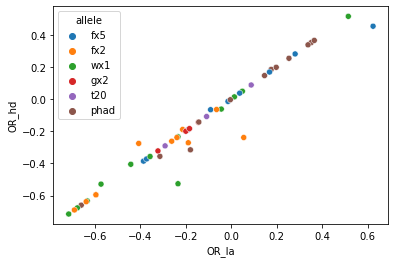

In [194]:
# sns.scatterplot(x='OR_la',y='OR_hd',data=alleleAllergenFreq,color='0.8')
sns.scatterplot(x='OR_la',y='OR_hd',data=alleleAllergenFreq.loc[mono_multi],hue='allele')

In [195]:
alleleSPX = alleleAllergenFreq.loc[mono_multi][['OR_la','OR_hd']].mean(axis=1).to_frame().reset_index().rename({0:'ORm'},axis=1)
alleleSPX['allele'] = [i.split("_")[1] for i in alleleSPX.allele_allergen.values]
alleleSPX['allergen'] = [i.split("_")[0] for i in alleleSPX.allele_allergen.values]
alleleSPXpvt = alleleSPX.pivot(index='allele',columns='allergen',values='ORm')
alleleSPXpvt

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/577926735.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  alleleSPX = alleleAllergenFreq.loc[mono_multi][['OR_la','OR_hd']].mean(axis=1).to_frame().reset_index().rename({0:'ORm'},axis=1)


allergen         fx2       fx5       gx2      phad       t20       wx1
allele                                                                
DPB1*04:02 -0.341364  0.539068       NaN       NaN       NaN       NaN
DPB1*09:01 -0.638357       NaN -0.183621  0.198065       NaN -0.633538
DPB1*10:01 -0.064539 -0.014277 -0.322368 -0.142640       NaN       NaN
DPB1*13:01       NaN       NaN       NaN       NaN       NaN -0.551003
DPB1*17:01 -0.230239       NaN       NaN       NaN       NaN       NaN
DQB1*03:03 -0.595459  0.281284 -0.144384       NaN       NaN  0.049201
DQB1*05:01       NaN       NaN       NaN  0.180309       NaN       NaN
DQB1*05:03       NaN       NaN       NaN       NaN       NaN -0.677105
DQB1*06:01 -0.690009       NaN       NaN       NaN       NaN       NaN
DQB1*06:03       NaN  0.037198       NaN       NaN       NaN       NaN
DQB1*06:04       NaN       NaN       NaN  0.351887       NaN       NaN
DRB1*01:01       NaN       NaN       NaN       NaN       NaN -0.357111
DRB1*01:02       NaN -0.385895       NaN  0.338024 -0.108263  0.515358
DRB1*08:04 -0.238956       NaN       NaN  0.146603       NaN -0.234137
DRB1*10:01       NaN       NaN       NaN  0.365563 -0.290983  0.014047
DRB1*11:01       NaN       NaN       NaN       NaN       NaN -0.052740
DRB1*11:04 -0.261897 -0.372343       NaN -0.660025       NaN -0.715177
DRB1*13:01       NaN  0.168554       NaN       NaN       NaN       NaN
DRB1*13:02       NaN       NaN       NaN  0.254185       NaN       NaN
DRB1*13:03 -0.091900 -0.189685 -0.199735 -0.247572  0.087947 -0.380388
DRB1*15:02       NaN       NaN       NaN       NaN       NaN -0.423748
DRB1*15:03 -0.595459       NaN       NaN -0.003844       NaN       NaN
DRB1*16:01 -0.201350 -0.078290       NaN -0.335003       NaN       NaN

In [196]:
protAF = pd.read_csv("../data_primary/AlleleFrequency_protRes_2methods.csv")
protAFIncluded = protAF[(protAF.selectedForStudy==1)].reset_index().drop('index',axis=1)

In [197]:
protAFIncluded.loc[protAFIncluded[(protAFIncluded.ProtRes.isin(alleleSPXpvt.index))].index,'AssociationFound']='AllergenAsso'
protAFIncluded  = protAFIncluded.fillna('NoAssociation')

<AxesSubplot:xlabel='gene', ylabel='AFprot_hd'>

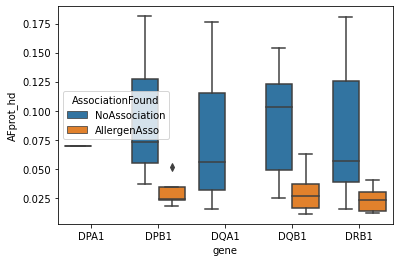

In [198]:
sns.boxplot(x='gene',y='AFprot_hd',data=protAFIncluded,hue='AssociationFound')

In [199]:
protAFIncluded.head()

ProtRes  AFprot_hd  AFprot_prg  errorConcord   AF_diff  gene molecule  \
0  DPA1*02:02   0.070000    0.063125             0  0.006875  DPA1       DP   
1  DPB1*01:01   0.036875    0.036875             0  0.000000  DPB1       DP   
2  DPB1*02:01   0.181250    0.181250             0  0.000000  DPB1       DP   
3  DPB1*04:02   0.034375    0.048125             0  0.013750  DPB1       DP   
4  DPB1*09:01   0.018125    0.018125             0  0.000000  DPB1       DP   

   selectedForStudy AssociationFound  
0                 1    NoAssociation  
1                 1    NoAssociation  
2                 1    NoAssociation  
3                 1     AllergenAsso  
4                 1     AllergenAsso

In [200]:
from statannot import add_stat_annotation

In [201]:
?add_stat_annotation(p)

Object `add_stat_annotation(p)` not found.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NoAssociation v.s. AllergenAsso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.145e-05 U_stat=4.270e+02


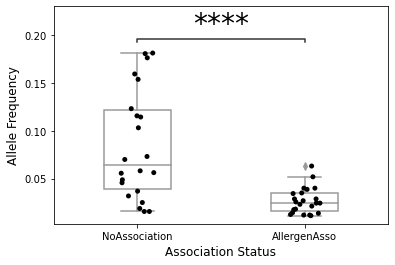

In [202]:
ordr = ['NoAssociation','AllergenAsso']
ax = sns.boxplot(x='AssociationFound',y='AFprot_hd',data=protAFIncluded,color='w',order=ordr,width=0.4)
sns.stripplot(x='AssociationFound',y='AFprot_hd',data=protAFIncluded,color='k')

test_res = add_stat_annotation(ax,data=protAFIncluded,x='AssociationFound',y='AFprot_hd',order=ordr,
                              box_pairs=[('NoAssociation','AllergenAsso')],
                              test='Mann-Whitney',text_format='star',
                              loc='inside',fontsize=28)
plt.xlabel("Association Status",fontsize=12)
plt.ylabel("Allele Frequency",fontsize=12)
plt.savefig("../figures/AssocitaionAlleleFrq.pdf",dpi=300,format='pdf')
plt.show()

In [203]:
print (stats.ks_2samp(protAFIncluded[protAFIncluded.AssociationFound==0].AFprot_hd.values,protAFIncluded[protAFIncluded.AssociationFound==1].AFprot_hd.values))
print (stats.mannwhitneyu(protAFIncluded[protAFIncluded.AssociationFound==0].AFprot_hd.values,protAFIncluded[protAFIncluded.AssociationFound==1].AFprot_hd.values))
print (stats.ttest_ind(protAFIncluded[protAFIncluded.AssociationFound==0].AFprot_hd.values,protAFIncluded[protAFIncluded.AssociationFound==1].AFprot_hd.values))

ValueError: Data passed to ks_2samp must not be empty

In [204]:
protAFIncluded.groupby('AssociationFound')[['AFprot_hd','AFprot_prg']].describe()

AFprot_hd                                                    \
                     count      mean       std       min       25%       50%   
AssociationFound                                                               
AllergenAsso          23.0  0.026848  0.013496  0.011250  0.015938  0.024375   
NoAssociation         22.0  0.084489  0.057307  0.015625  0.039062  0.064063   

                                     AFprot_prg                                \
                       75%       max      count      mean       std       min   
AssociationFound                                                                
AllergenAsso      0.034688  0.063125       23.0  0.027582  0.014161  0.011250   
NoAssociation     0.121250  0.181250       22.0  0.086051  0.055852  0.015625   

                                                         
                       25%       50%       75%      max  
AssociationFound                                         
AllergenAsso      0.016250  0.025625  0.036562  0.06250  
NoAssociation     0.043594  0.067812  0.141875  0.18125

In [205]:
hdGT = pd.read_csv("../data_primary/HLA_HD_protGT.csv").set_index("QBB_DUMMY_ID")

In [66]:
igE_clinic = pd.read_csv("../data_primary/clinicBool.csv").set_index("Unnamed: 0")

<AxesSubplot:ylabel='Frequency'>

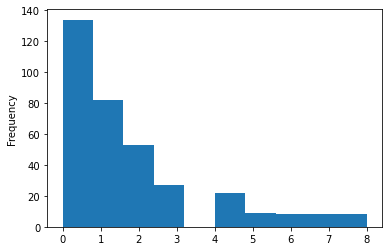

In [71]:
igE_clinic.loc[set(igE_clinic.index).intersection(riskAllel.index)].sum(axis=1).plot(kind='hist')

### Model 3: Sensitivity score and Allele

In [208]:
m3PS = pd.read_csv("../AssociationResults/PS_score_Model3_100_02-13-22_09:14:05.csv")

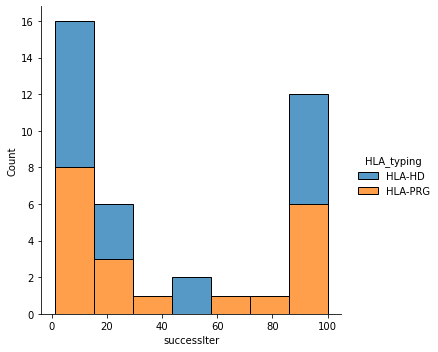

In [209]:
m3PS_sig = m3PS[(m3PS.pval_Holm<=0.005)&(abs(m3PS.coef)>np.log(2))]

m3PS_sig= m3PS_sig.reset_index().drop(['index','Unnamed: 0'],axis=1)
iterSize_m3 = m3PS_sig.groupby(['HLA_typing','allele']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize_m3,hue='HLA_typing',multiple='stack')

In [112]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize_m3.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)

0.75
0.75


HLA_typing
HLA-HD     93.00
HLA-PRG    88.75
Name: successIter, dtype: float64

In [210]:
iterSize_m3[iterSize_m3.successIter>=successThreshold]

HLA_typing      allele  successIter
2      HLA-HD  DPB1*10:01          100
8      HLA-HD  DQB1*06:04           96
10     HLA-HD  DRB1*01:02          100
14     HLA-HD  DRB1*11:04          100
16     HLA-HD  DRB1*13:03           90
18     HLA-HD  DRB1*16:01           98
21    HLA-PRG  DPB1*10:01          100
27    HLA-PRG  DQB1*06:04           96
29    HLA-PRG  DRB1*01:02          100
33    HLA-PRG  DRB1*11:04          100
37    HLA-PRG  DRB1*16:01           91

In [211]:
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter_m3 = iterSize_m3[iterSize_m3.successIter>10].groupby(['allele']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter_m3.head()

allele TypingCons
0  DPB1*09:01       Both
1  DPB1*10:01       Both
2  DPB1*14:01     HLA-HD
3  DQA1*01:03       Both
4  DQB1*05:02    HLA-PRG

In [212]:
curatedFilter_m3

allele TypingCons
0   DPB1*09:01       Both
1   DPB1*10:01       Both
2   DPB1*14:01     HLA-HD
3   DQA1*01:03       Both
4   DQB1*05:02    HLA-PRG
5   DQB1*06:03       Both
6   DQB1*06:04       Both
7   DRB1*01:02       Both
8   DRB1*04:03       Both
9   DRB1*11:04       Both
10  DRB1*13:01       Both
11  DRB1*13:03       Both
12  DRB1*15:01       Both
13  DRB1*16:01       Both

In [213]:
m3DF_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))

for k in curatedFilter_m3.index:
    _allele = curatedFilter_m3.loc[k,'allele']
    dx = m3PS_sig[(m3PS_sig.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    m3DF_Curated = pd.concat([m3DF_Curated,dx],axis=0)
    
m3DF_Curated = m3DF_Curated.reset_index().drop('index',axis=1)
m3DF_Curated_prg = m3DF_Curated[m3DF_Curated.HLA_typing=="HLA-PRG"]
m3DF_Curated_hd = m3DF_Curated[m3DF_Curated.HLA_typing=="HLA-HD"]

m3DF_Curated_agg = m3DF_Curated_prg.set_index("allele").join(m3DF_Curated_hd.set_index("allele"),lsuffix="_LA").sort_index()

In [214]:
m3DF_Curated_agg.sort_values("coef_LA")

HLA_typing_LA  iter_LA  coef_LA  [0.025_LA  0.975]_LA  \
allele                                                             
DRB1*11:04       HLA-PRG    100.0 -7.27740    -8.5940    -5.9595   
DPB1*10:01       HLA-PRG    100.0 -4.40765    -5.4735    -3.3420   
DQB1*05:02       HLA-PRG     12.0 -3.99965    -5.4220    -2.5880   
DRB1*04:03       HLA-PRG     83.0 -3.25310    -4.3020    -2.2020   
DRB1*15:01       HLA-PRG     20.0 -2.92095    -3.9230    -1.9195   
DRB1*16:01       HLA-PRG     91.0 -2.87620    -3.7600    -1.9720   
DRB1*13:03       HLA-PRG     88.0 -2.64410    -3.5150    -1.7685   
DPB1*09:01       HLA-PRG     30.0 -2.64130    -3.5900    -1.6925   
DPB1*14:01       HLA-PRG      2.0 -2.46510    -3.3750    -1.5550   
DQB1*06:03       HLA-PRG     20.0  2.33780     1.5035     3.1615   
DRB1*13:01       HLA-PRG     58.0  2.55970     1.7165     3.3990   
DQB1*06:04       HLA-PRG     96.0  2.69560     1.8875     3.5085   
DQA1*01:03       HLA-PRG     24.0  2.76295     1.8070     3.7460   
DRB1*01:02       HLA-PRG    100.0  3.88770     3.0170     4.7625   

            pval_Holm_LA HLA_typing   iter     coef  [0.025  0.975]  \
allele                                                                
DRB1*11:04  1.690906e-22     HLA-HD  100.0 -7.39145 -8.7285 -6.0710   
DPB1*10:01  1.873458e-11     HLA-HD  100.0 -4.41945 -5.4910 -3.3495   
DQB1*05:02  6.471874e-04     HLA-HD   10.0 -3.92335 -5.3000 -2.5465   
DRB1*04:03  7.811844e-05     HLA-HD   52.0 -3.26225 -4.3300 -2.2060   
DRB1*15:01  3.564161e-04     HLA-HD   23.0 -2.87680 -3.8570 -1.8830   
DRB1*16:01  1.132616e-05     HLA-HD   98.0 -3.30770 -4.2365 -2.3845   
DRB1*13:03  9.805104e-05     HLA-HD   90.0 -2.70635 -3.5960 -1.8270   
DPB1*09:01  1.408802e-03     HLA-HD   29.0 -2.77160 -3.7300 -1.8130   
DPB1*14:01  3.990458e-03     HLA-HD   12.0 -2.63815 -3.5690 -1.7075   
DQB1*06:03  1.695992e-03     HLA-HD   13.0  2.32610  1.5030  3.1500   
DRB1*13:01  1.014054e-04     HLA-HD   48.0  2.46405  1.6110  3.3225   
DQB1*06:04  4.603947e-06     HLA-HD   96.0  2.59825  1.7915  3.4145   
DQA1*01:03  1.045819e-03     HLA-HD   21.0  2.83710  1.8490  3.8480   
DRB1*01:02  1.442606e-13     HLA-HD  100.0  3.85930  2.9825  4.7355   

               pval_Holm  
allele                    
DRB1*11:04  6.050646e-23  
DPB1*10:01  2.025710e-11  
DQB1*05:02  9.464382e-04  
DRB1*04:03  1.103292e-04  
DRB1*15:01  3.638917e-04  
DRB1*16:01  3.585303e-08  
DRB1*13:03  5.569246e-05  
DPB1*09:01  6.679546e-04  
DPB1*14:01  1.210995e-03  
DQB1*06:03  2.177029e-03  
DRB1*13:01  4.472752e-04  
DQB1*06:04  1.268372e-05  
DQA1*01:03  6.824684e-04  
DRB1*01:02  1.807950e-13

In [215]:
m3DF_Curated_agg.loc[m3DF_Curated_agg[m3DF_Curated_agg[['iter_LA','iter']].min(axis=1)>90].index,'aType']='BothTyping'
m3DF_Curated_agg.loc[m3DF_Curated_agg[m3DF_Curated_agg[['iter_LA','iter']].min(axis=1)<=90].index,'aType']='OneTyping'
m3DF_Curated_agg

HLA_typing_LA  iter_LA  coef_LA  [0.025_LA  0.975]_LA  \
allele                                                             
DPB1*09:01       HLA-PRG     30.0 -2.64130    -3.5900    -1.6925   
DPB1*10:01       HLA-PRG    100.0 -4.40765    -5.4735    -3.3420   
DPB1*14:01       HLA-PRG      2.0 -2.46510    -3.3750    -1.5550   
DQA1*01:03       HLA-PRG     24.0  2.76295     1.8070     3.7460   
DQB1*05:02       HLA-PRG     12.0 -3.99965    -5.4220    -2.5880   
DQB1*06:03       HLA-PRG     20.0  2.33780     1.5035     3.1615   
DQB1*06:04       HLA-PRG     96.0  2.69560     1.8875     3.5085   
DRB1*01:02       HLA-PRG    100.0  3.88770     3.0170     4.7625   
DRB1*04:03       HLA-PRG     83.0 -3.25310    -4.3020    -2.2020   
DRB1*11:04       HLA-PRG    100.0 -7.27740    -8.5940    -5.9595   
DRB1*13:01       HLA-PRG     58.0  2.55970     1.7165     3.3990   
DRB1*13:03       HLA-PRG     88.0 -2.64410    -3.5150    -1.7685   
DRB1*15:01       HLA-PRG     20.0 -2.92095    -3.9230    -1.9195   
DRB1*16:01       HLA-PRG     91.0 -2.87620    -3.7600    -1.9720   

            pval_Holm_LA HLA_typing   iter     coef  [0.025  0.975]  \
allele                                                                
DPB1*09:01  1.408802e-03     HLA-HD   29.0 -2.77160 -3.7300 -1.8130   
DPB1*10:01  1.873458e-11     HLA-HD  100.0 -4.41945 -5.4910 -3.3495   
DPB1*14:01  3.990458e-03     HLA-HD   12.0 -2.63815 -3.5690 -1.7075   
DQA1*01:03  1.045819e-03     HLA-HD   21.0  2.83710  1.8490  3.8480   
DQB1*05:02  6.471874e-04     HLA-HD   10.0 -3.92335 -5.3000 -2.5465   
DQB1*06:03  1.695992e-03     HLA-HD   13.0  2.32610  1.5030  3.1500   
DQB1*06:04  4.603947e-06     HLA-HD   96.0  2.59825  1.7915  3.4145   
DRB1*01:02  1.442606e-13     HLA-HD  100.0  3.85930  2.9825  4.7355   
DRB1*04:03  7.811844e-05     HLA-HD   52.0 -3.26225 -4.3300 -2.2060   
DRB1*11:04  1.690906e-22     HLA-HD  100.0 -7.39145 -8.7285 -6.0710   
DRB1*13:01  1.014054e-04     HLA-HD   48.0  2.46405  1.6110  3.3225   
DRB1*13:03  9.805104e-05     HLA-HD   90.0 -2.70635 -3.5960 -1.8270   
DRB1*15:01  3.564161e-04     HLA-HD   23.0 -2.87680 -3.8570 -1.8830   
DRB1*16:01  1.132616e-05     HLA-HD   98.0 -3.30770 -4.2365 -2.3845   

               pval_Holm       aType  
allele                                
DPB1*09:01  6.679546e-04   OneTyping  
DPB1*10:01  2.025710e-11  BothTyping  
DPB1*14:01  1.210995e-03   OneTyping  
DQA1*01:03  6.824684e-04   OneTyping  
DQB1*05:02  9.464382e-04   OneTyping  
DQB1*06:03  2.177029e-03   OneTyping  
DQB1*06:04  1.268372e-05  BothTyping  
DRB1*01:02  1.807950e-13  BothTyping  
DRB1*04:03  1.103292e-04   OneTyping  
DRB1*11:04  6.050646e-23  BothTyping  
DRB1*13:01  4.472752e-04   OneTyping  
DRB1*13:03  5.569246e-05   OneTyping  
DRB1*15:01  3.638917e-04   OneTyping  
DRB1*16:01  3.585303e-08  BothTyping

In [219]:


m3DF_Curated_agg_toplot = m3DF_Curated_agg[m3DF_Curated_agg[['iter_LA','iter']].max(axis=1)>=successThreshold]
m3DF_Curated_agg_toplot

HLA_typing_LA  iter_LA  coef_LA  [0.025_LA  0.975]_LA  \
allele                                                             
DPB1*10:01       HLA-PRG    100.0 -4.40765    -5.4735    -3.3420   
DQB1*06:04       HLA-PRG     96.0  2.69560     1.8875     3.5085   
DRB1*01:02       HLA-PRG    100.0  3.88770     3.0170     4.7625   
DRB1*11:04       HLA-PRG    100.0 -7.27740    -8.5940    -5.9595   
DRB1*13:03       HLA-PRG     88.0 -2.64410    -3.5150    -1.7685   
DRB1*16:01       HLA-PRG     91.0 -2.87620    -3.7600    -1.9720   

            pval_Holm_LA HLA_typing   iter     coef  [0.025  0.975]  \
allele                                                                
DPB1*10:01  1.873458e-11     HLA-HD  100.0 -4.41945 -5.4910 -3.3495   
DQB1*06:04  4.603947e-06     HLA-HD   96.0  2.59825  1.7915  3.4145   
DRB1*01:02  1.442606e-13     HLA-HD  100.0  3.85930  2.9825  4.7355   
DRB1*11:04  1.690906e-22     HLA-HD  100.0 -7.39145 -8.7285 -6.0710   
DRB1*13:03  9.805104e-05     HLA-HD   90.0 -2.70635 -3.5960 -1.8270   
DRB1*16:01  1.132616e-05     HLA-HD   98.0 -3.30770 -4.2365 -2.3845   

               pval_Holm       aType  
allele                                
DPB1*10:01  2.025710e-11  BothTyping  
DQB1*06:04  1.268372e-05  BothTyping  
DRB1*01:02  1.807950e-13  BothTyping  
DRB1*11:04  6.050646e-23  BothTyping  
DRB1*13:03  5.569246e-05   OneTyping  
DRB1*16:01  3.585303e-08  BothTyping

In [220]:
m3DF_Curated_agg_toplot['coef_mean'] = m3DF_Curated_agg_toplot[['coef_LA','coef']].mean(axis=1)
m3DF_Curated_agg_toplot['lCI'] = m3DF_Curated_agg_toplot[['[0.025_LA','[0.025']].mean(axis=1)
m3DF_Curated_agg_toplot['mCI'] = m3DF_Curated_agg_toplot[['0.975]_LA','0.975]']].mean(axis=1)
m3DF_Curated_agg_toplot = m3DF_Curated_agg_toplot[['coef_mean','lCI','mCI','aType']].sort_values(by='coef_mean')

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/144411724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m3DF_Curated_agg_toplot['coef_mean'] = m3DF_Curated_agg_toplot[['coef_LA','coef']].mean(axis=1)
/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/144411724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m3DF_Curated_agg_toplot['lCI'] = m3DF_Curated_agg_toplot[['[0.025_LA','[0.025']].mean(axis=1)
/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_92922/144

In [221]:
m3DF_Curated_agg_toplot = m3DF_Curated_agg_toplot.reset_index()

In [222]:
m3DF_Curated_agg_toplot

allele  coef_mean      lCI      mCI       aType
0  DRB1*11:04  -7.334425 -8.66125 -6.01525  BothTyping
1  DPB1*10:01  -4.413550 -5.48225 -3.34575  BothTyping
2  DRB1*16:01  -3.091950 -3.99825 -2.17825  BothTyping
3  DRB1*13:03  -2.675225 -3.55550 -1.79775   OneTyping
4  DQB1*06:04   2.646925  1.83950  3.46150  BothTyping
5  DRB1*01:02   3.873500  2.99975  4.74900  BothTyping

In [223]:
baseX = alt.Chart(m3DF_Curated_agg_toplot,width=300,height=150).mark_point(filled=True,size=90,color='black').encode(
    x=alt.X('coef_mean',axis=alt.Axis(title="Coefficient of association (\u03b2) [CI]",titleFontSize=14)),
    y=alt.Y('allele',sort=list(m3DF_Curated_agg_toplot.allele.values)),
    shape=alt.Shape('aType',scale=alt.Scale(domain=['BothTyping','OneTyping'],range=['circle','square']),
                   legend=alt.Legend(title="Significance Associaition"))
       )
ebar = baseX.mark_errorbar().encode(
    y=alt.Y('allele',sort=list(m3DF_Curated_agg_toplot.allele.values),axis=alt.Axis(title='',labelFontSize=14)),
    x=alt.X("lCI",axis=alt.Axis(title='')),
    x2="mCI"
)
model3Plot = ebar+baseX

In [224]:
model3Plot

alt.LayerChart(...)

In [124]:
model3Plot

alt.LayerChart(...)

In [225]:
for k in m3DF_Curated_agg.index:
    m3DF_Curated_agg.loc[k,'beta_LA'] = "{} ({},{})".format(round(m3DF_Curated_agg.loc[k,'coef_LA'],2),
                                                                         round(m3DF_Curated_agg.loc[k,'[0.025_LA'],2),
                                                                         round(m3DF_Curated_agg.loc[k,'0.975]_LA'],2))
    
    m3DF_Curated_agg.loc[k,'beta_HD'] = "{} ({},{})".format(round(m3DF_Curated_agg.loc[k,'coef'],2),
                                                                         round(m3DF_Curated_agg.loc[k,'[0.025'],2),
                                                                         round(m3DF_Curated_agg.loc[k,'0.975]'],2))
m3DF_Curated_agg_print = m3DF_Curated_agg[['iter_LA','beta_LA','pval_Holm_LA','iter','beta_HD','pval_Holm','aType']]
m3DF_Curated_agg_print

iter_LA              beta_LA  pval_Holm_LA   iter  \
allele                                                          
DPB1*09:01     30.0  -2.64 (-3.59,-1.69)  1.408802e-03   29.0   
DPB1*10:01    100.0  -4.41 (-5.47,-3.34)  1.873458e-11  100.0   
DPB1*14:01      2.0  -2.47 (-3.38,-1.56)  3.990458e-03   12.0   
DQA1*01:03     24.0     2.76 (1.81,3.75)  1.045819e-03   21.0   
DQB1*05:02     12.0   -4.0 (-5.42,-2.59)  6.471874e-04   10.0   
DQB1*06:03     20.0      2.34 (1.5,3.16)  1.695992e-03   13.0   
DQB1*06:04     96.0      2.7 (1.89,3.51)  4.603947e-06   96.0   
DRB1*01:02    100.0     3.89 (3.02,4.76)  1.442606e-13  100.0   
DRB1*04:03     83.0    -3.25 (-4.3,-2.2)  7.811844e-05   52.0   
DRB1*11:04    100.0  -7.28 (-8.59,-5.96)  1.690906e-22  100.0   
DRB1*13:01     58.0      2.56 (1.72,3.4)  1.014054e-04   48.0   
DRB1*13:03     88.0  -2.64 (-3.51,-1.77)  9.805104e-05   90.0   
DRB1*15:01     20.0  -2.92 (-3.92,-1.92)  3.564161e-04   23.0   
DRB1*16:01     91.0  -2.88 (-3.76,-1.97)  1.132616e-05   98.0   

                        beta_HD     pval_Holm       aType  
allele                                                     
DPB1*09:01  -2.77 (-3.73,-1.81)  6.679546e-04   OneTyping  
DPB1*10:01  -4.42 (-5.49,-3.35)  2.025710e-11  BothTyping  
DPB1*14:01  -2.64 (-3.57,-1.71)  1.210995e-03   OneTyping  
DQA1*01:03     2.84 (1.85,3.85)  6.824684e-04   OneTyping  
DQB1*05:02   -3.92 (-5.3,-2.55)  9.464382e-04   OneTyping  
DQB1*06:03      2.33 (1.5,3.15)  2.177029e-03   OneTyping  
DQB1*06:04      2.6 (1.79,3.41)  1.268372e-05  BothTyping  
DRB1*01:02     3.86 (2.98,4.74)  1.807950e-13  BothTyping  
DRB1*04:03  -3.26 (-4.33,-2.21)  1.103292e-04   OneTyping  
DRB1*11:04  -7.39 (-8.73,-6.07)  6.050646e-23  BothTyping  
DRB1*13:01     2.46 (1.61,3.32)  4.472752e-04   OneTyping  
DRB1*13:03   -2.71 (-3.6,-1.83)  5.569246e-05   OneTyping  
DRB1*15:01  -2.88 (-3.86,-1.88)  3.638917e-04   OneTyping  
DRB1*16:01  -3.31 (-4.24,-2.38)  3.585303e-08  BothTyping

In [228]:
m3DF_Curated_agg_printX = m3DF_Curated_agg_print[m3DF_Curated_agg_print[['iter_LA','iter']].max(axis=1)>=successThreshold]

In [229]:
m3DF_Curated_agg_printX.to_csv("../tables/model3SignificantAsso_12May2022.csv")

## Haplotype Associaiton

In [8]:
m1HA = pd.read_csv("../AssociationResults/Haplotype-MonoSensitization_Model1_100_02-16-22_11:11:19.csv")
m1HA_sig = m1HA[(m1HA.pval_Holm<=p_valCut)&(abs(m1HA.coef)>coef_cut)] # significant association 

m1HA_sig= m1HA_sig.reset_index().drop(['index','Unnamed: 0'],axis=1)
m1HA_sig['AlleleAllergen'] = m1HA_sig.features+"_"+m1HA_sig.allele

print ("Assocations before filtering: ", m1HA.groupby("HLA_typing").size())
print ("Associaiton after filtering: ", m1HA_sig.groupby("HLA_typing").size())


Assocations before filtering:  HLA_typing
HLA-HD    14972
HLA-LA    14267
dtype: int64
Associaiton after filtering:  HLA_typing
HLA-HD    1254
HLA-LA    1387
dtype: int64


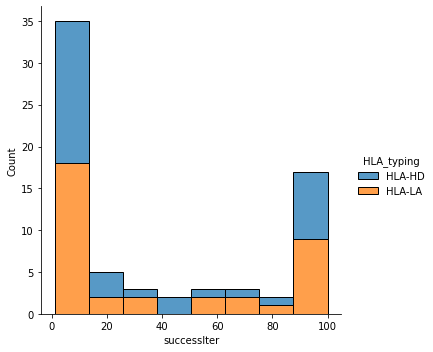

In [9]:
iterSize_hA = m1HA_sig.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize_hA,hue='HLA_typing',kind="hist",multiple='stack')

In [10]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize_hA.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)

0.75
0.75


HLA_typing
HLA-HD    80.75
HLA-LA    84.50
Name: successIter, dtype: float64

In [11]:
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter_m1HT = iterSize_hA[iterSize_hA.successIter>85].groupby(['allele','features']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter_m1HT.head()

allele features TypingCons
0  DRB1*04:02~DQA1*03:01~DQB1*03:02      fx2     HLA-HD
1  DRB1*04:03~DQA1*02:01~DQB1*02:01     phad     HLA-LA
2  DRB1*04:03~DQA1*02:01~DQB1*02:02     phad     HLA-HD
3  DRB1*07:01~DQA1*01:03~DQB1*02:01      fx5     HLA-LA
4  DRB1*07:01~DQA1*01:03~DQB1*02:01     phad     HLA-LA

In [12]:
m1HT_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))


for k in curatedFilter_m1HT.index:
    _allele = curatedFilter_m1HT.loc[k,'allele']
    _feature = curatedFilter_m1HT.loc[k,'features']
    dx = m1HA_sig[(m1HA_sig.features==_feature)&(m1HA_sig.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    dx['features'] = _feature
    m1HT_Curated = pd.concat([m1HT_Curated,dx],axis=0)
    
m1HT_Curated = m1HT_Curated.reset_index().drop('index',axis=1)

m1HT_Curated['test'] = m1HT_Curated.features+"_"+m1HT_Curated.allele
m1HT_Curated_prg = m1HT_Curated[m1HT_Curated.HLA_typing=="HLA-LA"]
m1HT_Curated_hd = m1HT_Curated[m1HT_Curated.HLA_typing=="HLA-HD"]

m1HT_Curated_agg = m1HT_Curated_prg.set_index("test").join(m1HT_Curated_hd.set_index("test"),lsuffix="_LA").sort_index()

In [14]:
m1HT_Curated_agg.to_csv("../data_curated/Haplotype_Model1.csv")

### Model 2 Haplotypes

In [16]:
m2HA = pd.read_csv("../AssociationResults/Haplotype-PolySensitization-Model2_100_02-16-22_12:32:57.csv")
m2HA_sig = m2HA[(m2HA.pval_Holm<=p_valCut)&(abs(m2HA.coef)>coef_cut)] # significant association 

m2HA_sig= m2HA_sig.reset_index().drop(['index','Unnamed: 0'],axis=1)
m2HA_sig['AlleleAllergen'] = m2HA_sig.features+"_"+m2HA_sig.allele

print ("Assocations before filtering: ", m2HA.groupby("HLA_typing").size())
print ("Associaiton after filtering: ", m2HA_sig.groupby("HLA_typing").size())

Assocations before filtering:  HLA_typing
HLA-HD    13880
HLA-LA    12976
dtype: int64
Associaiton after filtering:  HLA_typing
HLA-HD    907
HLA-LA    781
dtype: int64


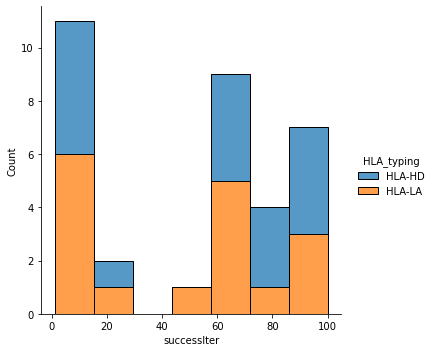

In [17]:
iterSize_hA2 = m2HA_sig.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize_hA2,hue='HLA_typing',kind="hist",multiple='stack')

In [18]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize_hA2.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)

0.75
0.75


HLA_typing
HLA-HD    85.0
HLA-LA    70.0
Name: successIter, dtype: float64

In [19]:
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter_m2HT = iterSize_hA2[iterSize_hA2.successIter>85].groupby(['allele','features']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter_m2HT.head()

allele features TypingCons
0  DRB1*03:01~DQA1*03:01~DQB1*02:01      gx2     HLA-LA
1  DRB1*04:02~DQA1*03:01~DQB1*03:02      fx2     HLA-HD
2  DRB1*07:01~DQA1*01:03~DQB1*02:01     phad     HLA-LA
3  DRB1*07:01~DQA1*01:03~DQB1*02:02     phad     HLA-HD
4  DRB1*07:01~DQA1*03:01~DQB1*03:02     phad     HLA-LA

In [39]:
m2HT_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))


for k in curatedFilter_m2HT.index:
    _allele = curatedFilter_m2HT.loc[k,'allele']
    _feature = curatedFilter_m2HT.loc[k,'features']
    dx = m2HA_sig[(m2HA_sig.features==_feature)&(m2HA_sig.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    dx['features'] = _feature
    m2HT_Curated = pd.concat([m2HT_Curated,dx],axis=0)
    
m2HT_Curated = m2HT_Curated.reset_index().drop('index',axis=1)

m2HT_Curated['test'] = m2HT_Curated.features+"_"+m2HT_Curated.allele
m2HT_Curated_prg = m2HT_Curated[m2HT_Curated.HLA_typing=="HLA-LA"]
m2HT_Curated_hd = m2HT_Curated[m2HT_Curated.HLA_typing=="HLA-HD"]

m2HT_Curated_agg = m2HT_Curated_prg.set_index("test").join(m2HT_Curated_hd.set_index("test"),lsuffix="_LA").sort_index()

In [40]:
m2HT_Curated_agg

HLA_typing_LA  iter_LA  coef_LA  \
test                                                                    
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01         HLA-LA     99.0   5.4315   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01        HLA-LA     96.0   2.1752   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02        HLA-LA     91.0  -2.0219   

                                       [0.025_LA  0.975]_LA  pval_Holm_LA  \
test                                                                        
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01      3.7650      7.082  1.762407e-06   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01     1.7335      2.617  1.614877e-17   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02    -2.5740     -1.472  8.017489e-09   

                                                              allele_LA  \
test                                                                      
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01   DRB1*03:01~DQA1*03:01~DQB1*02:01   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01  DRB1*07:01~DQA1*01:03~DQB1*02:01   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02  DRB1*07:01~DQA1*03:01~DQB1*03:02   

                                      features_LA HLA_typing  iter    coef  \
test                                                                         
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01          gx2        NaN   NaN     NaN   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01        phad        NaN   NaN     NaN   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02        phad     HLA-HD  85.0 -2.0621   

                                       [0.025  0.975]     pval_Holm  \
test                                                                  
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01      NaN     NaN           NaN   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01     NaN     NaN           NaN   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02  -2.626  -1.499  1.847106e-08   

                                                                 allele  \
test                                                                      
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01                                NaN   
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01                               NaN   
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02  DRB1*07:01~DQA1*03:01~DQB1*03:02   

                                      features  
test                                            
gx2_DRB1*03:01~DQA1*03:01~DQB1*02:01       NaN  
phad_DRB1*07:01~DQA1*01:03~DQB1*02:01      NaN  
phad_DRB1*07:01~DQA1*03:01~DQB1*03:02     phad

In [41]:
m2HT_Curated_agg.to_csv("../data_curated/Haplotype_Model2.csv")

In [23]:
## Model 3

In [24]:
m3HA = pd.read_csv("../AssociationResults/Haplotype-PS_score_Model3_100_02-16-22_12:29:11.csv")
m3HA_sig = m3HA[(m3HA.pval_Holm<=p_valCut)&(abs(m3HA.coef)>coef_cut)] # significant association 

m3HA_sig= m3HA_sig.reset_index().drop(['index','Unnamed: 0'],axis=1)
m3HA_sig['AlleleAllergen'] = m3HA_sig.features+"_"+m3HA_sig.allele

print ("Assocations before filtering: ", m3HA.groupby("HLA_typing").size())
print ("Associaiton after filtering: ", m3HA_sig.groupby("HLA_typing").size())

Assocations before filtering:  HLA_typing
HLA-HD    1900
HLA-LA    1800
dtype: int64
Associaiton after filtering:  HLA_typing
HLA-HD    525
HLA-LA    538
dtype: int64


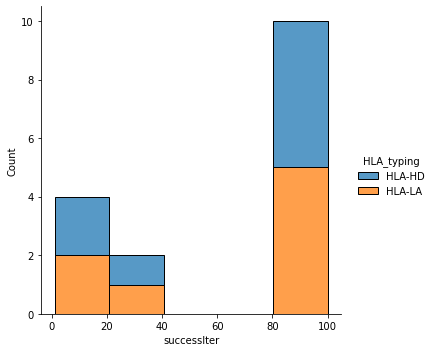

In [25]:
iterSize_hA3 = m3HA_sig.groupby(['HLA_typing','allele','features']).size().reset_index().rename({0:'successIter'},axis=1)
sns.displot(x='successIter',data=iterSize_hA3,hue='HLA_typing',kind="hist",multiple='stack')

In [26]:
def getQuantile(sv,qval=0.75):
    print (qval)
    return (sv.quantile(qval))

iterSize_hA3.groupby("HLA_typing")["successIter"].apply(getQuantile,qval=0.75)

0.75
0.75


HLA_typing
HLA-HD    100.0
HLA-LA    100.0
Name: successIter, dtype: float64

In [27]:
def getConS(kgrp):
    if kgrp.HLA_typing.nunique()==2:
        return 'Both'
    else:
        return kgrp.HLA_typing.unique()[0]
    
curatedFilter_m3HT = iterSize_hA3[iterSize_hA3.successIter>90].groupby(['allele','features']).apply(getConS).reset_index().rename({0:'TypingCons'},axis=1)
curatedFilter_m3HT.head()

allele features TypingCons
0  DRB1*04:02~DQA1*03:01~DQB1*03:02  psScore     HLA-HD
1  DRB1*04:03~DQA1*02:01~DQB1*02:01  psScore     HLA-LA
2  DRB1*04:03~DQA1*02:01~DQB1*02:02  psScore     HLA-HD
3  DRB1*07:01~DQA1*03:01~DQB1*03:02  psScore       Both
4  DRB1*11:04~DQA1*05:01~DQB1*03:01  psScore     HLA-LA

In [36]:
m3HT_Curated = pd.DataFrame()

def valAggregate(kgrp):
    return (kgrp[['iter','coef','[0.025','0.975]','pval_Holm']].agg({'iter':'size','coef':'median','[0.025':'median','0.975]':'median','pval_Holm':'median'}))


for k in curatedFilter_m3HT.index:
    _allele = curatedFilter_m3HT.loc[k,'allele']
    _feature = curatedFilter_m3HT.loc[k,'features']
    dx = m3HA_sig[(m3HA_sig.features==_feature)&(m3HA_sig.allele==_allele)].groupby("HLA_typing").apply(valAggregate).reset_index()
    dx['allele'] = _allele
    dx['features'] = _feature
    m3HT_Curated = pd.concat([m3HT_Curated,dx],axis=0)
    
m3HT_Curated = m3HT_Curated.reset_index().drop('index',axis=1)

m3HT_Curated['test'] = m3HT_Curated.features+"_"+m3HT_Curated.allele
m3HT_Curated_prg = m3HT_Curated[m3HT_Curated.HLA_typing=="HLA-LA"]
m3HT_Curated_hd = m3HT_Curated[m3HT_Curated.HLA_typing=="HLA-HD"]

m3HT_Curated_agg = m3HT_Curated_prg.set_index("test").join(m3HT_Curated_hd.set_index("test"),lsuffix="_LA").sort_index()

In [37]:
m3HT_Curated_agg

HLA_typing_LA  iter_LA   coef_LA  \
test                                                                        
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01        HLA-LA    100.0  -4.82345   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02        HLA-LA    100.0  -5.22255   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01        HLA-LA    100.0 -17.01135   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02        HLA-LA    100.0 -11.46465   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01        HLA-LA    100.0   6.33675   

                                          [0.025_LA  0.975]_LA  pval_Holm_LA  \
test                                                                           
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01    -6.2190    -3.4320  2.199025e-07   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02    -6.7650    -3.6860  7.138464e-07   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01   -20.5530   -13.4565  6.996209e-17   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02   -13.8130    -9.1170  5.792554e-18   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01     4.7205     7.9550  2.829657e-10   

                                                                 allele_LA  \
test                                                                         
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01  DRB1*04:03~DQA1*02:01~DQB1*02:01   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02  DRB1*07:01~DQA1*03:01~DQB1*03:02   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01  DRB1*11:04~DQA1*05:01~DQB1*03:01   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02  DRB1*15:01~DQA1*01:02~DQB1*05:02   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01  DRB1*15:13~DQA1*02:01~DQB1*02:01   

                                         features_LA HLA_typing   iter  \
test                                                                     
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01     psScore        NaN    NaN   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02     psScore     HLA-HD   97.0   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01     psScore        NaN    NaN   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02     psScore     HLA-HD  100.0   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01     psScore        NaN    NaN   

                                              coef  [0.025  0.975]  \
test                                                                 
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01       NaN     NaN     NaN   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02  -4.64420  -6.060  -3.192   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01       NaN     NaN     NaN   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02 -12.33195 -14.814  -9.845   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01       NaN     NaN     NaN   

                                             pval_Holm  \
test                                                     
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01           NaN   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02  2.544491e-06   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01           NaN   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02  3.988155e-18   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01           NaN   

                                                                    allele  \
test                                                                         
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01                               NaN   
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02  DRB1*07:01~DQA1*03:01~DQB1*03:02   
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01                               NaN   
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02  DRB1*15:01~DQA1*01:02~DQB1*05:02   
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01                               NaN   

                                         features  
test                                               
psScore_DRB1*04:03~DQA1*02:01~DQB1*02:01      NaN  
psScore_DRB1*07:01~DQA1*03:01~DQB1*03:02  psScore  
psScore_DRB1*11:04~DQA1*05:01~DQB1*03:01      NaN  
psScore_DRB1*15:01~DQA1*01:02~DQB1*05:02  psScore  
psScore_DRB1*15:13~DQA1*02:01~DQB1*02:01      NaN

In [38]:
m3HT_Curated_agg.to_csv("../data_curated/Haplotype_Model3.csv")